# Análisis de Privacidad de Usuario: ¿Cambio natural de paradigma o agenda forzada?
## Trabajo Integrador Individual
## "De Texto Crudo a Insights: Pipeline Completo de Análisis de NLP"

**Fecha de entrega**: Jueves 25 de septiembre  

---

## Import de librerias

In [2]:
## 1.X
import requests
from bs4 import BeautifulSoup
import pandas as pd

import os
import re
import shutil
from google.colab import files
from urllib.parse import urlparse

# Manejo de errores
import traceback

## 2.X
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy

from collections import Counter

## 3.X
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.manifold import TSNE


In [ ]:
# Import pesado - Ejecutar una sola vez
# Stanza, para otros modelos de lematizacion
!pip install stanza
import stanza
# Descargar el modelo para español (solo la primera vez)
stanza.download('es')

# Manejo de errores en commits
#!pip install nbstripout

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 45.1 MB/s eta 0:00:00


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


## Contexto

### 1.0 Selección de ideas anteriores

#### Intento de Corpus literario

Se han revisado varias fuentes posibles de información para cuentos contemporáneos o de autores latinoamericanos pero encontré varios problemas a la hora de seleccionar el corpus de este formato que cumpla con el criterio minimo de volumen para procesarlo...

#### Project Gutenberg
Usando https://www.gutenberg.org/browse/languages/es

Autor elegido: Blasco Ibáñez, Vicente, 1867-1928

No tenia suficiente volumen digerible para cuentos y las obras parecían dispersas y repetidas

No tuve forma de encontrar en una forma concisa autores argentinos o latinoamericanos que estén en Gutenberg y que dispongan de mucho material usable para el proyecto... Podria buscar a mano pero tardaria mucho

Se intentó recolectar datos con
* Cuentos valencianos
https://www.gutenberg.org/ebooks/66514

* La condenada (cuentos)
https://www.gutenberg.org/ebooks/27736

* La Catedral

Entre otros...

#### Biblioteca Digital Argentina
La página no se encuentra disponible, y las alternativas no son lo suficientemente voluminosas o contemporaneas para el target que se busca

#### Cervantes Virtual
Mayoritariamente autores españoles, se buscaban autores latinoamericanos

#### Ciudad Seva
De algun modo no me convenció del todo, y preferí buscar otro tipo de corpus para entonces

### 1.1 Descripción del corpus elegido
Se decide entonces recolectar información relacionada al tema *tecnología*, con énfasis en el asunto de **privacidad**.

#### Fuentes seleccionadas

Fuentes elegidas
- https://derechodelared.com/
- https://www.anred.org/
- https://www.pagina12.com.ar/

Se omiten otros sitios periodisticos como Clarin, La Nación e Infobae ya que no proporcionaban suficiente información relevante al filtro que queremos aplicar

---

Yapa - No usables pero interesantes para tener en RSS posiblemente?
- https://www.elladodelmal.com/
- (Listado con más blogs y sitios periodisticos) https://www.genbeta.com/seguridad/17-expertos-blogs-y-newsletter-a-seguir-si-de-verdad-te-interesan-seguridad-y-privacidad


### 1.2 Justificación de elección

#### ¿Por qué este corpus?

La razón principal ocurre por dos factores:
- A nivel temático, es un asunto contemporáneo que, como otros rubros de la ciencia, está constantemente en transformación y más considerando las tendencias de desarrollos de tecnologías automatizadas que se profundizaron en la última década.
- Al ser un asunto popular, aporta un buen volumen con suficiente variabilidad para elegir algún tema específico sin que falten recursos para hacer una retrospectiva
- Si bien fue un tema de debate durante el 2015 al 2020, el asunto de privacidad e integridad de datos de usuario es un tema que sigue siendo relevante y que no habria que perder de vista, más considerando el factor de recolección de datos usados para modelos de IA

#### ¿Qué buscamos descubrir?

El enfoque de este corpus a analizar es el poder encontrar más contexto sobre los actores en juego a la hora de avanzar con ciertos cambios en la cotidianeidad del uso de nuestros datos personales

#### Hipotesis: "¿De verdad es necesario todo esto?"
¿Son realmente necesarias las nuevas exigencias en los términos y condiciones modificados?

¿Por qué se necesitan nuevas regulaciones año tras año de parte de protección de datos?

¿El factor económico de redistribución de datos personales sigue siendo tan presente como hace 5 años?

La hipótesis que planteo es que si bien se vió enlentecido el proceso de nuevos requerimientos que involucren vender nuestra privacidad de datos personales, sigue siendo igual de relevante que durante la década pasada.


### 1.3 Proceso de recolección

Los textos fueron obtenidos a mano a través de las fuentes mencionadas en 1.1, utilizando las palabras "privacidad" y "datos personales" en los buscadores integrados de dichas páginas. Se ha incluido una fuente adicional usando un buscador como DuckDuckGo.

#### Criterios de inclusión/exclusión

Se determina la exclusión de artículos que contengan:
- Alto contenido en imágenes en formato de infografías
- Contenido relacionado a la privacidad de una persona en particular (política/celebridad o no), a menos que se mencione información que aporte al contexto general del corpus
- Anuncios de aplicaciones nuevas que puedan proporcionar alternativas a las comunes (usualmente están orientadas a cubrir las características del programa en vez de informar en general)

#### Dificultades y obstáculos

En la obtención de recursos he encontrado los siguientes obstáculos:

- Calidad de artículos gratuitos. Se encontraron los suficientes para cubrir casos recientes, pero muchos artículos se encuentran restringidos para usuarios registrados a newsletters.
- Web scraping - La estructura de metadatos HTML varía mucho entre distintas fuentes. Un ejemplo de esto es al buscar el título de los artículos de www.derechodelared.com, la falta de dato de autor en los de www.anred.org, o los formatos variantes en fechas, etc.
- Falta de tiempo para organizarme mejor. Muchas tareas en paralelo impidieron una mejor calidad de recolección.


### 1.4 Estadísticas básicas

#### Código inicial

##### Obtención de listado de URLs
Las urls a probar de mi corpus están guardadas en un .txt dentro del repositorio

In [ ]:
# 003_barthou-gonzalo-nlp-integrador/corpus/corpusList.txt

# URL cruda del archivo en GitHub
github_txt_url = "https://raw.githubusercontent.com/gimb99/PDH_BARTHOU_GONZALO/refs/heads/main/003_barthou-gonzalo-nlp-integrador/corpus/corpusList.txt"

# Descargar y procesar las líneas
response = requests.get(github_txt_url)
lines = response.text.splitlines()
urls = [line.strip() for line in lines if line.strip()]


##### Guardado de .txt como archivos raw

In [ ]:
# Crear carpeta para guardar los archivos
folder = "raw_texts"
os.makedirs(folder, exist_ok=True)

# Función para limpiar el nombre del archivo
def clean_filename(title, index):
    title = re.sub(r'[^\w\s-]', '', title).strip().replace(' ', '_')
    return f"{index:03d}_{title[:50]}.txt"  # Limita el nombre a 50 caracteres

default_no_disponible = "No disponible"

# Recorrer las URLs
for i, url in enumerate(urls, start=1):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Extraer título y texto (ajustar según el sitio)
        domain = urlparse(url).netloc
        try:
          if "derechodelared.com" in domain:
            title = soup.find("meta", property="og:title")["content"]
            autor_crudo = soup.find("a", attrs={"rel": "author"})
            autor_tag = default_no_disponible
            if autor_crudo:
              autor_tag = autor_crudo.get_text(strip=True)

            fecha_tag = soup.find("meta", property="article:published_time")["content"]
            categoria_tag = soup.find("a", rel="category tag").get_text(strip=True)
          elif "www.pagina12.com" in domain:
            title = soup.find("meta", property="og:title")["content"]
            autor_tag = soup.find("meta", property="article:author")["content"]
            fecha_tag = soup.find("meta", property="article:published_time")["content"]
            categoria_tag = soup.find("meta", property="article:section")["content"]
          elif "anred" in domain:
            title = soup.find("meta", property="og:title")["content"]
            # No se encuentran autores en muchos articulos, se procede a dejar en default
            # autor_tag = soup.find("meta", property="article:author")["content"]
            autor_tag = default_no_disponible
            #fecha_tag = soup.find("div", class_="date text-muted")
            # 1. Localizar el div
            fecha_crudo = soup.find("div", class_="date text-muted")
            # 2. Extraer solo el texto y limpiarlo
            fecha_texto = fecha_crudo.get_text(strip=True)  # -> "14/03/2023"
            # 3. Parsear a objeto fecha de Python
            from datetime import datetime
            fecha_tag = datetime.strptime(fecha_texto, "%d/%m/%Y")

            categoria_tag = soup.find("meta", property="article:section")["content"]
          else:
            title = soup.find("h1").get_text(strip=True)
        except Exception as e:
          print(f"❌ Error con datos de {url}: {e}")
          traceback.print_exc()
          title = f"articulo_{i}"

        paragraphs = soup.find_all("p")

        # Guardado datos en variables
        text = "\n".join([p.get_text(strip=True) for p in paragraphs])
        #autor_fuente = autor_tag.get_text(strip=True) if autor_tag else default_no_disponible
        autor_fuente = autor_tag if autor_tag else default_no_disponible
        #fecha = fecha_tag.get_text(strip=True) if fecha_tag else ""
        fecha = fecha_tag if fecha_tag else default_no_disponible
        #categoria = categoria_tag.get_text(strip=True) if categoria_tag else default_no_disponible
        categoria = categoria_tag if categoria_tag else default_no_disponible

        # Guardar como archivo .txt
        filename = clean_filename(title, i)
        filepath = os.path.join(folder, filename)

        with open(filepath, "w", encoding="utf-8") as f:
            f.write(f"URL: {url}\n")
            f.write(f"Título: {title}\n")
            f.write(f"Autor: {autor_fuente}\n")
            f.write(f"Fecha: {fecha}\n")
            f.write(f"Categoría: {categoria}\n\n")
            f.write(text)

        print(f"✅ Guardado: {filename}")

    except Exception as e:
        print(f"❌ Error con {url}: {e}")

✅ Guardado: 001_Tiktok_se_enfrenta_a_una_posible_multa_de_27_millo.txt
✅ Guardado: 002_Manzana_podrida_decenas_de_exespías_israelíes_fuer.txt
✅ Guardado: 003_El_auge_del_tecnofeudalismo__ANRed.txt
✅ Guardado: 004_Qué_hay_detrás_de_las_colas_para_la_venta_de_iris_.txt
✅ Guardado: 005_Sam_Altman_creador_de_ChatGPT_y_GPT-4_mi_peor_temo.txt
✅ Guardado: 006_Natalia_Zuazo_el_problema_es_cuando_el_avance_de_l.txt
✅ Guardado: 007_Espionaje_ilegal_del_Ministerio_de_Seguridad_porte.txt
✅ Guardado: 008_Pensamiento_crítico_De_verdad_sabemos_qué_hacemos_.txt
✅ Guardado: 009_CABA_la_Legislatura_porteña_debate_un_polémico_pro.txt
✅ Guardado: 010_WhatsApp_no_cerrará_cuentas_pero_limitará_funcione.txt
✅ Guardado: 011_Polisis_una_IA_que_se_lee_las_políticas_de_privaci.txt
✅ Guardado: 012_La_AEPD_presenta_nuevos_recursos_para_fomentar_la_.txt
✅ Guardado: 013_Chat_Control_el_plan_europeo_para_escanear_tus_men.txt
✅ Guardado: 014_La_NSA_compra_datos_de_navegación_de_los_usuarios_.txt
✅ Guardado: 015_Micros

##### Textos debug / desarrollo - Ignorar

Elminar carpeta para reintentar

In [ ]:
# Eliminar carpeta

# folder = "raw_texts"
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#             print(f"🗑️ Borrado: {filename}")
#     except Exception as e:
#         print(f"❌ Error con {filename}: {e}")

Guardado de zip

In [ ]:
# Guardado de .zip para luego extraerlo y subirlo a github
# shutil.make_archive("raw_texts", "zip", "raw_texts")
# files.download("raw_texts.zip")

##### Guardado de metadata.csv v2

In [ ]:
folder = "raw_texts"
metadata = []

for filename in os.listdir(folder):
    filepath = os.path.join(folder, filename)

    if os.path.isfile(filepath) and filename.endswith(".txt"):
        with open(filepath, "r", encoding="utf-8") as f:
            content = f.read()

        # Separar líneas para buscar metadatos
        lines = content.splitlines()

        # Extraer título, autor, fecha, categoría (si están presentes)
        titulo = ""
        autor_fuente = ""
        fecha = ""
        categoria = ""

        for line in lines[:10]:  # Buscar en las primeras líneas
            if line.lower().startswith("título:"):
                titulo = line.split(":", 1)[1].strip()
            elif line.lower().startswith("autor:") or line.lower().startswith("fuente:"):
                autor_fuente = line.split(":", 1)[1].strip()
            elif line.lower().startswith("fecha:"):
                fecha = line.split(":", 1)[1].strip()
            elif line.lower().startswith("categoría:"):
                categoria = line.split(":", 1)[1].strip()

        # Calcular número aproximado de palabras
        cuerpo = "\n".join(lines[10:])  # Suponiendo que el cuerpo empieza después de los metadatos
        palabras_aprox = len(cuerpo.split())

        metadata.append({
            "archivo": filename,
            "titulo": titulo,
            "autor_fuente": autor_fuente,
            "fecha": fecha,
            "categoria": categoria,
            "palabras_aprox": palabras_aprox
        })

# Guardar como CSV
df = pd.DataFrame(metadata)
df.to_csv("metadata.csv", index=False)


#### Número total de textos


##### Paso 0 - Get de metadata.csv desde GitHub

In [ ]:
# Opción A: si subiste metadata.csv directamente al espacio de Colab
# df = pd.read_csv("metadata.csv")

# Opcion B / Obtener de github
# URL cruda del archivo en GitHub
github_metadata_url = "https://raw.githubusercontent.com/gimb99/PDH_BARTHOU_GONZALO/refs/heads/main/003_barthou-gonzalo-nlp-integrador/corpus/metadata.csv"

# Descargar y procesar las líneas
# response = requests.get(github_txt_url)
df = pd.read_csv(github_metadata_url)

##### Paso Real

In [ ]:
# 2.1 Número total de textos
total_textos = len(df)
print("Total de textos:", total_textos)

Total de textos: 26


#### Número total de palabras

In [ ]:
total_palabras = df["palabras_aprox"].sum()
print("Total aproximado de palabras:", total_palabras)

Total aproximado de palabras: 25695


#### Distribución de tamaños de documentos

count      26.000000
mean      988.269231
std       841.510526
min        61.000000
25%       283.000000
50%       706.000000
75%      1776.250000
max      2585.000000
Name: palabras_aprox, dtype: float64


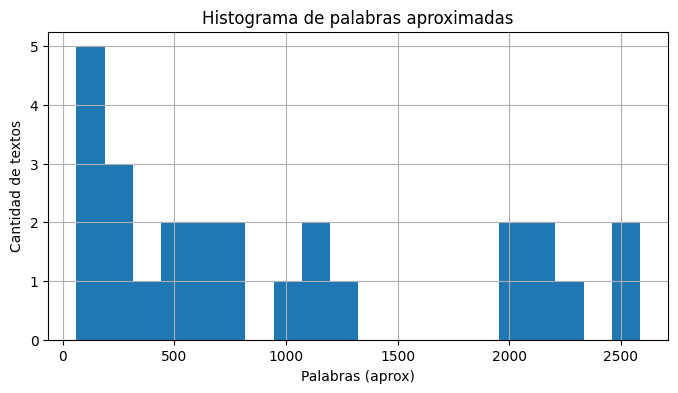

In [ ]:
# Estadísticos básicos
print(df["palabras_aprox"].describe())

plt.figure(figsize=(8,4))
df["palabras_aprox"].hist(bins=20)
plt.title("Histograma de palabras aproximadas")
plt.xlabel("Palabras (aprox)")
plt.ylabel("Cantidad de textos")
plt.show()


#### Gráfico de distribución temporal

/tmp/ipython-input-4053633844.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")


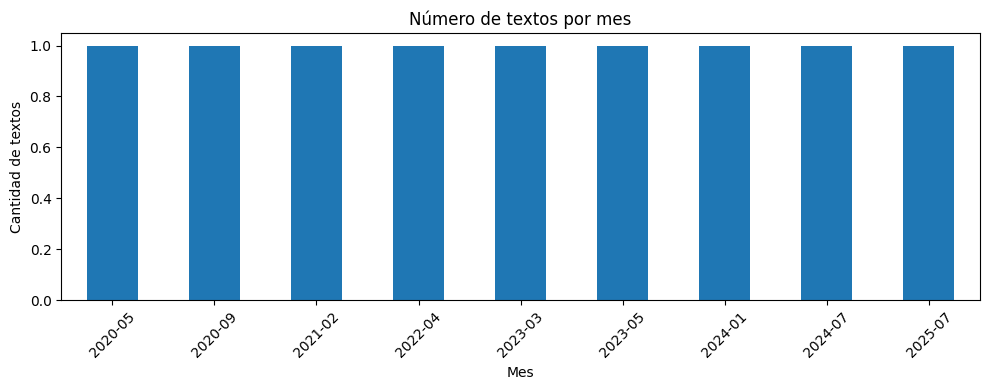

In [ ]:
# Convertir 'fecha' a datetime (ajusta el formato si es necesario)
df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")

# Agrupar por mes
df_mes = df.groupby(df["fecha"].dt.to_period("M")).size()

# Dibujar
df_mes.plot(kind="bar", figsize=(10,4))
plt.title("Número de textos por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de textos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La distribución no da resultados eficientes dado que no se obtuvo una fecha con el mismo formato para todos los artículos. Por tanto, no es posible aplicar una distribución temporal a menos que se fixee el formato final en metadata.csv

### 1.5 Exploración inicial

##### Carga de datos

In [ ]:
# Limpiador
def clean_text(text):
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar emails
    text = re.sub(r'\S+@\S+', '', text)
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar puntuación y caracteres especiales (solo dejar letras y espacios)
    text = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', ' ', text)
    # Reemplazar múltiples espacios por uno solo
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Directorio donde están los archivos .txt
corpus_dir = "/content/raw_texts/"  # Ajusta esta ruta

pattern = re.compile(r"URL:.*?\n\n(.*)", re.DOTALL)
all_texts = []

for filename in os.listdir(corpus_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(corpus_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            match = pattern.search(content)
            if match:
                text_body = match.group(1).strip()
                # Limpiar el texto antes de agregarlo
                cleaned_text = clean_text(text_body)  # Asumiendo que tienes esta función
                all_texts.append(cleaned_text)

# Verificar cómo se están uniendo los textos
print("Primeros 1000 caracteres de corpus_full_text:")
corpus_full_text = " ".join(all_texts)
print(repr(corpus_full_text[:1000]))

# Ahora `texts` contiene solo los cuerpos de los artículos

Primeros 1000 caracteres de corpus_full_text:
'La Agencia de Seguridad Nacional de Estados Unidos NSA ha admitido haber comprado registros de navegación por Internet a empresas especializadas en la recopilación de datos para vigilar la actividad en línea de los estadounidenses sin tener una orden judicial para ello La noticia ha saltado después de que el senador demócrata estadounidenseRon Wyden hiciese públicos unos documentos dónde se confirmaque la Agencia de Seguridad Nacional NSA compra los registros de navegación por Internet de los estadounidenses sin orden judicial Pueden parecer datos sin importancia pero a través de ellos se puede saber las webs que visitan los ciudadanos estadounidenses que aplicaciones tienen intereses inquietudes Mucha información Por ello Wyden ha pedido al Gobierno norteamericano que cesen en esta practica remarcando que según una orden reciente de la Comisión Federal de Comercio FTC estas empresas que se dedican a la recopilación masiva de datos no pued

#### Mostrar fragmentos representativos

In [ ]:
# Mostrar primeros 300 caracteres de los primeros 3 textos
for i, text in enumerate(texts[:3]):
    print(f"Fragmento del texto {i+1}:")
    print(text[:300])
    print("-" * 50)

Fragmento del texto 1:
La Agencia de Seguridad Nacional de Estados Unidos NSA ha admitido haber comprado registros de navegación por Internet a empresas especializadas en la recopilación de datos para vigilar la actividad en línea de los estadounidenses sin tener una orden judicial para ello La noticia ha saltado después 
--------------------------------------------------
Fragmento del texto 2:
LaAgencia Española de Protección de Datos AEPD ha presentado junto con elMinisterio de Educación Cultura y Deportenuevos recursos y materiales de ayuda para fomentar la privacidad y la protección de datos de los menores Estos recursos se incorporan a la web de la AgenciaTú decides en internet un pro
--------------------------------------------------
Fragmento del texto 3:
La digitalización de nuestras relaciones cotidianas provoca que cedamos datos personales infinidad de veces al día Y los cambios constantes no permiten que lo hagamos de forma consciente e informada Por Elena Gil González Resum

#### Nube de palabras inicial

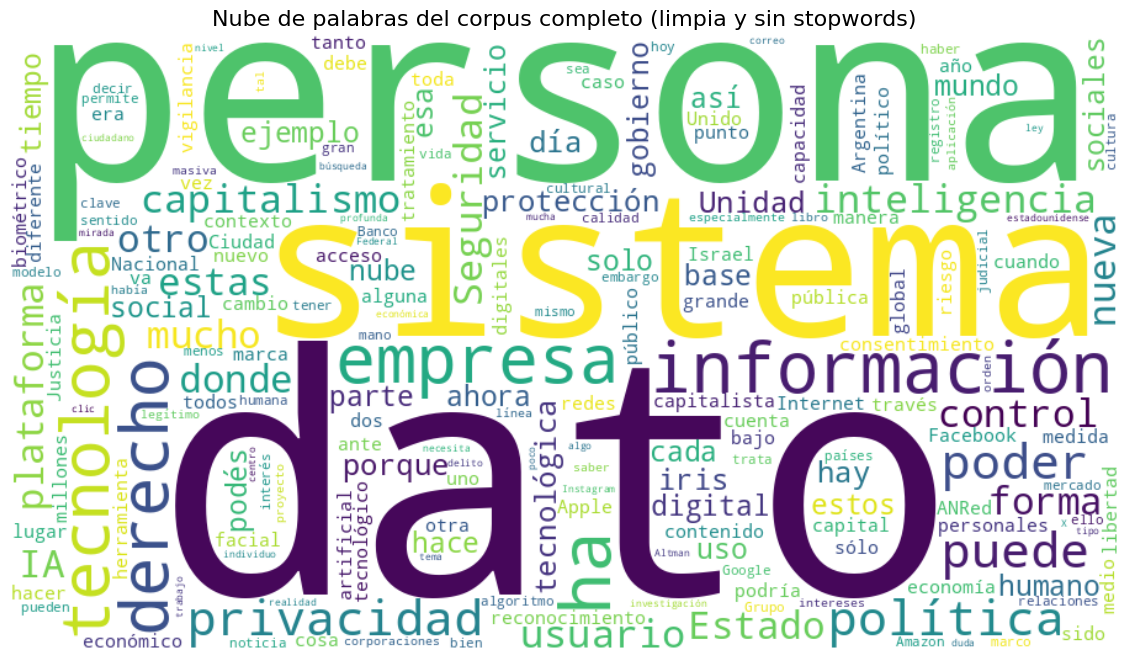

In [ ]:
from wordcloud import STOPWORDS

# Agregar stopwords en español
spanish_stopwords = {
     "el", "la", "de", "que", "y", "a", "en", "un", "es", "se", "no", "te", "lo", "le", "da",
    "su", "por", "son", "con", "para", "al", "del", "los", "las", "una", "como", "pero",
    "sus", "han", "muy", "sin", "sobre", "ser", "todo", "esta", "hasta", "fue", "más",
    "son", "han", "tiene", "han", "haya", "tienen", "tendrá", "tienen", "está", "están",
    "mi", "mis", "tu", "tus", "su", "sus", "nos", "vos", "vosotros", "ustedes", "yo", "él",
    "ella", "nosotros", "ellos", "ellas", "me", "te", "le", "nos", "os", "les", "lo", "la",
    "los", "las", "mío", "mía", "míos", "mías", "tuyo", "tuya", "tuyos", "tuyas", "suyo",
    "suya", "suyos", "suyas", "nuestro", "nuestra", "nuestros", "nuestras", "vuestro",
    "vuestra", "vuestros", "vuestras", "esto", "eso", "aquello", "este", "ese", "aquel",
    "aquí", "ahí", "allí", "cuándo", "dónde", "cómo", "qué", "quién", "cuánto", "cuánta",
    "cuántos", "cuántas", "por qué", "para qué", "hacia", "entre", "desde", "hasta", "contra",
    "según", "durante", "mediante", "salvo", "excepto", "incluso", "mientras", "aunque",
    "si", "sino", "o", "ni", "pero", "mas", "y", "e", "u", "o", "ya", "todavía", "aún",
    "siempre", "nunca", "jamás", "también", "tampoco", "además", "asimismo", "igualmente",
    "finalmente", "entonces", "luego", "por tanto", "por consiguiente", "por ende", "por lo tanto"
}
stopwords = set(STOPWORDS)
stopwords.update(spanish_stopwords)

# Generar la nube
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=200,
    stopwords=stopwords,
    colormap="viridis",
    collocations=False,
    ).generate(corpus_full_text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras del corpus completo (limpia y sin stopwords)", fontsize=16)
plt.show()

#### Debugging - Ignorar

## Análisis Técnico

###  2.1: Carga y organización de datos

#### Unificando metadata con corpus

In [ ]:
import pandas as pd
import os
import re

# Cargar el archivo metadata.csv
github_metadata_url = "https://raw.githubusercontent.com/gimb99/PDH_BARTHOU_GONZALO/refs/heads/main/003_barthou-gonzalo-nlp-integrador/corpus/metadata.csv"
metadata_path = github_metadata_url
metadata_df = pd.read_csv(metadata_path)

# Directorio donde están los archivos .txt
#corpus_dir = "/content/drive/MyDrive/corpus_txt"  # Ajusta esta ruta

# Patrón para extraer solo el cuerpo del texto
pattern = re.compile(r"URL:.*?\n\n(.*)", re.DOTALL)

# Diccionario para almacenar cuerpos de texto indexados por nombre de archivo
corpus_dict = {}

for filename in os.listdir(corpus_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(corpus_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            match = pattern.search(content)
            if match:
                text_body = match.group(1).strip()
                corpus_dict[filename] = text_body
            else:
                print(f"Advertencia: No se pudo extraer el cuerpo de {filename}")

# Añadir el cuerpo del texto al DataFrame
metadata_df['cuerpo'] = metadata_df['archivo'].apply(lambda x: corpus_dict.get(x, None))

# Verificar si hay valores faltantes en la columna 'cuerpo'
print("Verificación de integridad:")
print(f"Total de documentos en metadata: {len(metadata_df)}")
print(f"Documentos con cuerpo de texto: {metadata_df['cuerpo'].notna().sum()}")
print(f"Documentos sin cuerpo de texto: {metadata_df['cuerpo'].isna().sum()}")

Verificación de integridad:
Total de documentos en metadata: 26
Documentos con cuerpo de texto: 26
Documentos sin cuerpo de texto: 0


#### Valido que se hayan cargado correctamente

In [ ]:
# Mostrar las primeras filas para verificar la integración
print("\nPrimeras filas del DataFrame integrado:")
print(metadata_df[['archivo', 'titulo', 'autor_fuente', 'fecha', 'categoria', 'palabras_aprox', 'cuerpo']].head())


Primeras filas del DataFrame integrado:
                                             archivo  \
0         003_El_auge_del_tecnofeudalismo__ANRed.txt   
1  011_Polisis_una_IA_que_se_lee_las_políticas_de...   
2  007_Espionaje_ilegal_del_Ministerio_de_Segurid...   
3  023_Apple_multada_Francia_sanciona_con_162_mil...   
4  004_Qué_hay_detrás_de_las_colas_para_la_venta_...   

                                              titulo    autor_fuente  \
0                El auge del tecnofeudalismo | ANRed   No disponible   
1  Polisis: una IA que se lee las políticas de pr...  Julio San José   
2  Espionaje ilegal del Ministerio de Seguridad p...   No disponible   
3  Apple multada: Francia sanciona con $162 millo...        Página12   
4  ¿Qué hay detrás de las colas para la venta de ...   No disponible   

                       fecha             categoria  palabras_aprox  \
0        2024-07-14 00:00:00               Opinión            2585   
1  2019-10-30T18:00:50+00:00                 Cybe

#### Guardado en Pickle inicial

In [ ]:
# Guardar en un archivo .pkl para futuras operaciones
metadata_df.to_pickle("corpus_crudo.pkl")

#### Validacion de fechas inconsistentes
Dado que no pude obtener fechas de forma consistente por usar varias fuentes, pruebo si es posible pasar a tenerlas en un formato date_time

Encontramos que la mayoria de los datos de fecha son no validos para hacer un pasaje, de igual forma intenta recuperarse los que son validos...

##### Conversión fecha Epoch

In [ ]:
# Función para intentar convertir fechas EPOCH
def convertir_fecha_epoch(valor):
    try:
        # Intentar convertir a número
        epoch = float(valor)
        # Verificar si es un timestamp razonable (entre 1970 y 2030 aprox.)
        if 315360000 < epoch < 2000000000:  # Años entre 1980 y 2033 aprox.
            return pd.to_datetime(epoch, unit='s')
        else:
            return pd.NaT  # No es una fecha válida
    except:
        return pd.NaT

In [ ]:
# Asumiendo que tienes el DataFrame con la columna 'fecha'
df = pd.read_pickle("corpus_crudo.pkl")  # Si ya lo tienes guardado

# Intentar convertir las fechas inválidas como si fueran EPOCH
df['fecha_dt'] = pd.to_datetime(df['fecha'], errors='coerce')
df['fecha_epoch'] = df['fecha'].apply(convertir_fecha_epoch)

# Combinar las fechas válidas con las convertidas desde EPOCH
df['fecha_final'] = df['fecha_dt'].fillna(df['fecha_epoch'])

# Verificar cuántas fechas pudieron convertirse ahora
validas = df['fecha_final'].notna().sum()
invalidas = df['fecha_final'].isna().sum()

print(f"Fechas válidas tras intento de conversión EPOCH: {validas}")
print(f"Fechas aún inválidas: {invalidas}")

# Mostrar las fechas aún inválidas
fechas_invalidas = df[df['fecha_final'].isna()]
print("\nFechas aún inválidas:")
print(fechas_invalidas[['archivo', 'fecha']])

Fechas válidas tras intento de conversión EPOCH: 19
Fechas aún inválidas: 7

Fechas aún inválidas:
                                              archivo  \
1   011_Polisis_una_IA_que_se_lee_las_políticas_de...   
6   013_Chat_Control_el_plan_europeo_para_escanear...   
8   015_Microsoft_mantendrá_en_la_UE_los_datos_per...   
18  014_La_NSA_compra_datos_de_navegación_de_los_u...   
22  012_La_AEPD_presenta_nuevos_recursos_para_fome...   
23  001_Tiktok_se_enfrenta_a_una_posible_multa_de_...   
24  010_WhatsApp_no_cerrará_cuentas_pero_limitará_...   

                        fecha  
1   2019-10-30T18:00:50+00:00  
6   2025-09-14T18:15:40+00:00  
8   2024-01-15T18:29:59+00:00  
18  2024-01-29T19:07:17+00:00  
22  2017-10-23T18:34:41+00:00  
23  2022-09-26T18:15:45+00:00  
24  2021-05-11T19:04:55+00:00  


##### Correccion de fechas en formato ISO 8601

In [ ]:
# Intentar convertir las fechas que aún están como inválidas
fechas_restantes = df[df['fecha_final'].isna()]

# Intentar convertir con formato ISO 8601 explícito
df.loc[df['fecha_final'].isna(), 'fecha_final'] = pd.to_datetime(
    df[df['fecha_final'].isna()]['fecha'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce'
)

# Verificar cuántas fechas pudieron convertirse ahora
validas = df['fecha_final'].notna().sum()
invalidas = df['fecha_final'].isna().sum()

print(f"Fechas válidas tras intento de conversión ISO 8601: {validas}")
print(f"Fechas aún inválidas: {invalidas}")

# Mostrar las fechas aún inválidas
fechas_invalidas = df[df['fecha_final'].isna()]
if not fechas_invalidas.empty:
    print("\nFechas aún inválidas:")
    print(fechas_invalidas[['archivo', 'fecha']])
else:
    print("\n¡Todas las fechas pudieron convertirse!")

Fechas válidas tras intento de conversión ISO 8601: 26
Fechas aún inválidas: 0

¡Todas las fechas pudieron convertirse!


/tmp/ipython-input-1088535155.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
['2019-10-30 18:00:50+00:00', '2025-09-14 18:15:40+00:00',
 '2024-01-15 18:29:59+00:00', '2024-01-29 19:07:17+00:00',
 '2017-10-23 18:34:41+00:00', '2022-09-26 18:15:45+00:00',
 '2021-05-11 19:04:55+00:00']
Length: 7, dtype: datetime64[ns, UTC]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[df['fecha_final'].isna(), 'fecha_final'] = pd.to_datetime(


In [ ]:
# Etiquetar si la fecha es válida o no
df['fecha_valida'] = df['fecha_final'].notna()

# Mostrar estadísticas
print("\nResumen de fechas:")
print(df['fecha_valida'].value_counts())


Resumen de fechas:
fecha_valida
True    26
Name: count, dtype: int64


#### Guardo dataframe limpio como Pickle

In [ ]:
# Guardar el DataFrame con la columna de fechas completamente corregida
df.to_pickle("corpus_limpio.pkl")

In [ ]:
print(df["fecha_final"])

0           2024-07-14 00:00:00
1     2019-10-30 18:00:50+00:00
2           2022-04-13 00:00:00
3           2025-04-03 15:24:34
4           2024-01-11 00:00:00
5           2024-12-20 21:20:46
6     2025-09-14 18:15:40+00:00
7           2025-04-05 20:52:35
8     2024-01-15 18:29:59+00:00
9           2023-05-17 00:00:00
10          2025-05-06 11:20:50
11          2021-02-21 00:00:00
12          2025-07-31 00:00:00
13          2025-05-06 11:20:50
14          2025-06-17 14:41:58
15          2020-05-09 00:00:00
16          2025-08-21 20:59:46
17          2025-08-21 20:59:46
18    2024-01-29 19:07:17+00:00
19          2025-03-27 19:58:54
20          2023-03-14 00:00:00
21          2025-08-30 00:31:10
22    2017-10-23 18:34:41+00:00
23    2022-09-26 18:15:45+00:00
24    2021-05-11 19:04:55+00:00
25          2020-09-18 00:00:00
Name: fecha_final, dtype: object


### 2.2 Limpieza de texto

In [ ]:
import string

def clean_text_v2(text):
    # 1. Conversión a minúsculas
    # Justificación: Ayuda a que palabras como "La" y "la" se consideren iguales
    text = text.lower()

    # 2. Eliminación de signos de puntuación
    # Justificación: Elimina símbolos como .,;:!? que no aportan significado semántico
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Eliminación de números
    # Justificación: En este corpus (noticias), los números no son relevantes para el análisis
    text = re.sub(r'\d+', '', text)

    # 4. Eliminación de caracteres especiales y espacios extra
    # Justificación: Quita caracteres como \n, \t, y múltiples espacios
    text = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cargar el DataFrame con los cuerpos de texto
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio.pkl"
df = pd.read_pickle(github_pkl_path)

# Aplicar la limpieza a la columna 'cuerpo'
# Ya disponiamos de una funcion anteriormente, pero esta vez haremos
# una segunda pasada mas refinada
df['cuerpo_limpio'] = df['cuerpo'].apply(clean_text_v2)

# Mostrar una comparación antes y después
print("Antes de limpiar:")
print(df['cuerpo'].iloc[0][:500])
print("\nDespués de limpiar:")
print(df['cuerpo_limpio'].iloc[0][:500])

Antes de limpiar:
El capitalismo tal como lo conocíamos, afirma Yanis Varoufakis, ha mutado tanto que ha dado lugar a un nuevo sistema. En el tecnofeudalismo, los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas, y la burguesía de antaño está al servicio de una nueva clase dominante, aquella que es dueña de la nube. PorDavid Moscorp paraJacobin/ traducción: Florencia Oroz.
controvertido concepto de tecnofeudalismo sugiere que hemos pasado del capitalismo a algo aún peor: una

Después de limpiar:
el capitalismo tal como lo conocíamos afirma yanis varoufakis ha mutado tanto que ha dado lugar a un nuevo sistema en el tecnofeudalismo los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas y la burguesía de antaño está al servicio de una nueva clase dominante aquella que es dueña de la nube pordavid moscorp parajacobin traducción florencia oroz controvertido concepto de tecnofeudalismo sugiere que hemos pasado del ca

#### Pasos realizados
- Conversión de todo el corpus a minúsculas para normalización de texto
- Eliminación de signos de puntuación para optimizar valor semántico
- Eliminación de valores numéricos literales, así como de caracteres no imprimibles o especiales (éste ultimo ya estaba forzado por UTF-8 de todas formas)
- Reemplazo de múltiples espacios por uno simple para minimizar errores de análisis posteriores

#### Guardado de Corpus Limpio v2 como Pickle

In [ ]:
# Guardar el DataFrame con los cuerpos limpios
df.to_pickle("corpus_limpio_v2.pkl")

### 2.3 Tokenización y normalización

#### ¿Qué es stemming y lemmatization?

- Stemming: Reduce las palabras a su raíz truncando el final (por ejemplo: "corriendo" → "corr").
- Lemmatization: Reduce las palabras a su forma base (lema) considerando el contexto gramatical (por ejemplo: "corriendo" → "correr").

#### ¿Qué usar?
Usaremos Lemmatization, ya que si bien es más lento, el uso de textos en español reduce la usabilidad analítica al usar Stemming y puede provocar una perdida de contexto en palabras complejas (el idioma tiene muchas formas verbales y variaciones gramaticales)

#### Aplicación

In [ ]:
## Librerias usadas: nltk, spacy

# Descargar recursos necesarios
#nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Descarga forzada de modelo en español
!python -m spacy download es_core_news_sm

# Cargar modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 37.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##### Tokenizacion (Pre-Normalizado)

In [ ]:
# Cargar el DataFrame con los textos limpios
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v2.pkl"
df = pd.read_pickle(github_pkl_path)

# Ejemplo de texto limpio
ejemplo_texto = df['cuerpo_limpio'].iloc[0]
print("Texto limpio (ejemplo):")
print(ejemplo_texto[:500])

Texto limpio (ejemplo):
el capitalismo tal como lo conocíamos afirma yanis varoufakis ha mutado tanto que ha dado lugar a un nuevo sistema en el tecnofeudalismo los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas y la burguesía de antaño está al servicio de una nueva clase dominante aquella que es dueña de la nube pordavid moscorp parajacobin traducción florencia oroz controvertido concepto de tecnofeudalismo sugiere que hemos pasado del capitalismo a algo aún peor una nueva era 


In [ ]:
# Tokenizar el texto
tokens = word_tokenize(ejemplo_texto)
print("\nTokens (antes de normalización):")
print(tokens[:20])


Tokens (antes de normalización):
['el', 'capitalismo', 'tal', 'como', 'lo', 'conocíamos', 'afirma', 'yanis', 'varoufakis', 'ha', 'mutado', 'tanto', 'que', 'ha', 'dado', 'lugar', 'a', 'un', 'nuevo', 'sistema']


##### Lematización

In [ ]:
# Función para lematizar texto
def lemmatize_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

# Aplicar lematización
lemmatized_tokens = lemmatize_text(ejemplo_texto)
print("\nTokens lematizados (después de normalización):")
print(lemmatized_tokens[:20])


Tokens lematizados (después de normalización):
['el', 'capitalismo', 'tal', 'como', 'él', 'conocíar', 'afirmar', 'yani', 'varoufakis', 'haber', 'mutar', 'tanto', 'que', 'haber', 'dar', 'lugar', 'a', 'uno', 'nuevo', 'sistema']


In [ ]:
### Debug
doc = nlp("conocíamos")
for token in doc:
    print(f"Palabra: {token.text}")
    print(f"Lema: {token.lemma_}")
    print(f"POS (Part-of-Speech): {token.pos_}")
    print(f"Tag (etiqueta detallada): {token.tag_}")
    print(f"¿Es verbo?: {token.pos_ == 'VERB'}")
    print("---")

Palabra: conocíamos
Lema: conocíar
POS (Part-of-Speech): VERB
Tag (etiqueta detallada): VERB
¿Es verbo?: True
---


#### Obstáculo

En la ejecución de esta ultima linea, llegué a notar que hay algunos verbos conjugados que se lematizan de forma incorrecta, esto puede ser ocasionado por una versión anterior del modelo de spaCy en español que puede disponer de imprecisiones como con la palabra "Conocíamos", que la traduce como "conocíar", de forma que ese verbo infinitivo no existe

Probaremos con `Stanza` a ver si tenemos suerte...



In [ ]:
# Stanza - Usado con !pip, importa y modelo en español

# Inicializar el pipeline
nlp_stanza = stanza.Pipeline('es', processors='tokenize,pos,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
# Procesar la oración
doc = nlp_stanza("conocíamos")

for sentence in doc.sentences:
    for word in sentence.words:
        print(f"Palabra: {word.text}, Lema: {word.lemma}")

Palabra: conocíamos, Lema: conocer


#### Prueba de nuevo con Stanza

In [ ]:
# Inicializar el pipeline de Stanza para español (solo una vez)
nlp_stanza = stanza.Pipeline('es', processors='tokenize,pos,lemma')

def lemmatize_with_stanza(text):
    doc = nlp_stanza(text)
    # Extraer solo los lemas de palabras que no son puntuación
    return [word.lemma for sent in doc.sentences for word in sent.words if word.pos != 'PUNCT']

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
# Cargar el DataFrame con los textos limpios
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v2.pkl"
df = pd.read_pickle(github_pkl_path)

# Aplicar lematización con Stanza
df['tokens_lemmatizados'] = df['cuerpo_limpio'].apply(lemmatize_with_stanza)

# Mostrar un ejemplo
print("Antes de normalización (texto limpio):")
print(df['cuerpo_limpio'].iloc[0][:300])
print("\nDespués de lematización con Stanza:")
print(df['tokens_lemmatizados'].iloc[0][:20])

Antes de normalización (texto limpio):
el capitalismo tal como lo conocíamos afirma yanis varoufakis ha mutado tanto que ha dado lugar a un nuevo sistema en el tecnofeudalismo los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas y la burguesía de antaño está al servicio de una nueva clase dominante 

Después de lematización con Stanza:
['el', 'capitalismo', 'tal', 'como', 'él', 'conocer', 'afirmar', 'yanis', 'varoufakis', 'haber', 'mutar', 'tanto', 'que', 'haber', 'dar', 'lugar', 'a', 'uno', 'nuevo', 'sistema']


#### Guardado de corpus_limpio v3 (Stanza)


In [ ]:
# Guardar el DataFrame con los tokens lematizados
df.to_pickle("corpus_limpio_v3.pkl")

### 2.4 Manejo de Stop Words

In [ ]:
# nltk.corpus / stopwords, nltk, pandas

# Descargar stopwords
nltk.download('stopwords')

# Cargar el DataFrame con los tokens lematizados
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3.pkl"
df = pd.read_pickle(github_pkl_path)

# Obtener stopwords en español
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Agregar palabras específicas del dominio (opcional, ajusta según tu corpus)
"""
domain_stopwords = {
    "estados", "unidos", "nsa", "senador", "ley", "leyes", "gobierno", "estadounidenses",
    "estadounidense", "datos", "usuario", "usuarios", "web", "webs", "aplicaciones",
    "información", "privacidad", "política", "políticas", "internet", "navegación",
    "comisión", "ftc", "dónde", "a través", "según", "artículo", "artículos", "sitio",
    "sitios", "empresa", "empresas", "informe", "informes", "documento", "documentos"
}
"""

domain_stopwords = {
    "sistema", "dato", "persona", "ser", "poder", "haber", "tener", "hacer",
    "si", "nuevo", "seguir", "decir", "ir", "sólo", "cómo", "dar", "información",
	"tecnología", "sino", "vez", "inteligencia", "tecnológico", "ejemplo", "cada"
}

stop_words.update(domain_stopwords)

# Función para quitar stopwords
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Aplicar la función
df['tokens_sin_stopwords'] = df['tokens_lemmatizados'].apply(remove_stopwords)

# Mostrar impacto
print("Antes de quitar stopwords (primeros 20 tokens):")
print(df['tokens_lemmatizados'].iloc[0][:20])
print("\nDespués de quitar stopwords (primeros 20 tokens):")
print(df['tokens_sin_stopwords'].iloc[0][:20])

# Contar cuántas palabras se quitaron
antes = len(df['tokens_lemmatizados'].iloc[0])
despues = len(df['tokens_sin_stopwords'].iloc[0])
print(f"\nTokens antes: {antes}, después: {despues}, stopwords removidas: {antes - despues}")

Antes de quitar stopwords (primeros 20 tokens):
['el', 'capitalismo', 'tal', 'como', 'él', 'conocer', 'afirmar', 'yanis', 'varoufakis', 'haber', 'mutar', 'tanto', 'que', 'haber', 'dar', 'lugar', 'a', 'uno', 'nuevo', 'sistema']

Después de quitar stopwords (primeros 20 tokens):
['capitalismo', 'tal', 'conocer', 'afirmar', 'yanis', 'varoufakis', 'mutar', 'lugar', 'tecnofeudalismo', 'usuario', 'contribuir', 'formación', 'capital', 'interactuar', 'plataforma', 'burguesía', 'antaño', 'servicio', 'clase', 'dominante']

Tokens antes: 2846, después: 1236, stopwords removidas: 1610


#### Justificación de las decisiones
- Stopwords estándar

Palabras como "el", "la", "de", etc. no aportan valor semántico en análisis de texto.

- Stopwords específicas del dominio

Palabras como "persona", "dato", "persona" son comunes en el corpus, pero no aportan significado para diferenciar entre artículos.



In [ ]:
# Guardar el DataFrame con los tokens sin stopwords
df.to_pickle("corpus_limpio_v3_stopwords.pkl")

### 2.5 Estadísticas de post-procesamiento

Ahora vamos a calcular:

Vocabulario final (número de palabras únicas).

Distribución de frecuencias.

Comparación antes/después del preprocesamiento.

In [ ]:
# Cargar el DataFrame actualizado
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/develop/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3_stopwords.pkl"
df = pd.read_pickle(github_pkl_path)

In [ ]:
# Contar frecuencia de palabras en todos los documentos
all_tokens = [token for tokens in df['tokens_sin_stopwords'] for token in tokens]
freq_dist = Counter(all_tokens)

print(f"Vocabulario final (palabras únicas): {len(freq_dist)}")
print("\nPalabras más frecuentes:")
print(freq_dist.most_common(20))

# Comparar antes y después de quitar stopwords
all_tokens_antes = [token for tokens in df['tokens_lemmatizados'] for token in tokens]
freq_dist_antes = Counter(all_tokens_antes)

print(f"\nVocabulario antes de quitar stopwords: {len(freq_dist_antes)}")
print(f"Vocabulario después de quitar stopwords: {len(freq_dist)}")

Vocabulario final (palabras únicas): 4372

Palabras más frecuentes:
[('empresa', 69), ('derecho', 66), ('digital', 62), ('deber', 51), ('privacidad', 51), ('capitalismo', 50), ('usuario', 49), ('política', 48), ('social', 48), ('seguridad', 48), ('control', 46), ('humano', 45), ('público', 44), ('plataforma', 43), ('protección', 42), ('forma', 41), ('día', 39), ('iris', 39), ('unidad', 39), ('ia', 38)]

Vocabulario antes de quitar stopwords: 4452
Vocabulario después de quitar stopwords: 4372


#### Distribucion de frecuencias

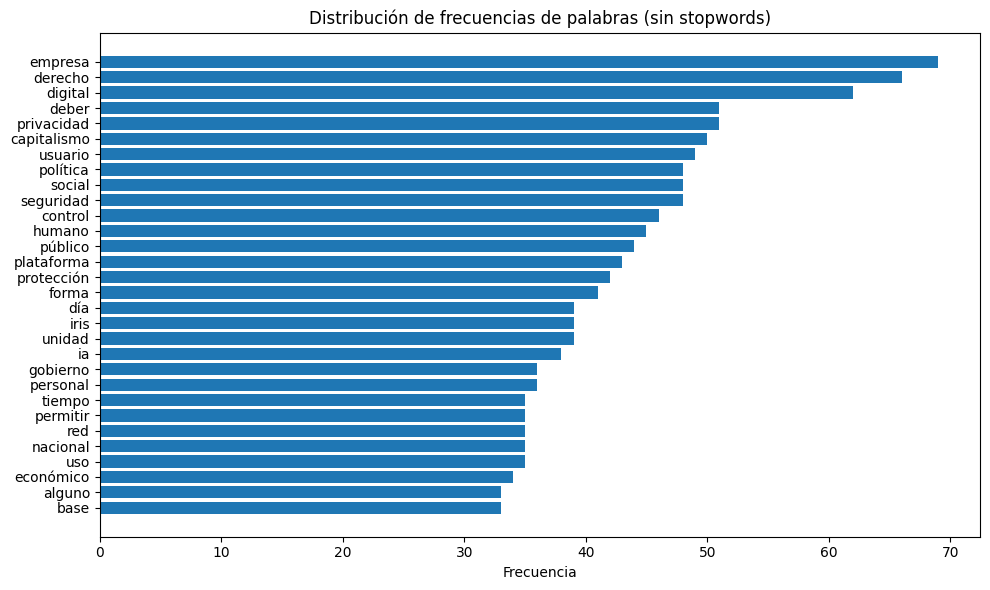

In [ ]:
import matplotlib.pyplot as plt

# Convertir a DataFrame para graficar
freq_df = pd.DataFrame(freq_dist.most_common(30), columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(10, 6))
plt.barh(freq_df['Palabra'], freq_df['Frecuencia'])
plt.xlabel('Frecuencia')
plt.title('Distribución de frecuencias de palabras (sin stopwords)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Se visualiza a partir de esta distribución de frecuencias que todavía debe darse un refinado extra para palabras que aportan poco valor como:

"vez", "día", "tecnológico", "tecnología", etc

## Análisis con BoW/TF-IDF

### 3.1 Vectorización del corpus

##### Repaso de Bag of Words vs TF-IDF

BoW representa cada documento como un vector de conteos de palabras. Ignora el orden, solo importa cuántas veces aparece cada palabra del vocabulario total.

La desventaja, es que BoW solo cuenta. No diferencia entre palabras comunes (en el corpus) y palabras distintivas.

**TF-IDF (Term Frequency - Inverse Document Frequency)** intenta solucionar esto.

*   **TF (Frecuencia del Término):** ¿Qué tan frecuente es una palabra *en este documento*? (Similar a BoW, a veces normalizado).
*   **IDF (Frecuencia Inversa de Documento):** ¿Qué tan *rara* es la palabra *en toda la colección* de documentos?
    *   Palabras que aparecen en muchos documentos (como quizás "el", "la" si no las quitáramos) tienen IDF bajo (son poco informativas).
    *   Palabras que aparecen en pocos documentos tienen IDF alto (son más distintivas).
*   **TF-IDF = TF * IDF:** El peso final de una palabra en un documento es alto si es frecuente en ESE documento pero rara en general.

**Resultado:** Una matriz Documento-Término similar a BoW, pero con pesos TF-IDF en lugar de conteos crudos.

In [2]:
# Cargar el DataFrame actualizado
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/develop/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3_stopwords.pkl"
df = pd.read_pickle(github_pkl_path)

In [3]:
# Reconstruir los documentos como cadenas de texto
df['texto_procesado'] = df['tokens_sin_stopwords'].apply(lambda x: ' '.join(x))

# Crear matriz de Bag-of-Words - documento-término con CountVectorizer
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(df['texto_procesado'])

# Crear matriz TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_procesado'])


#### Características de matrices

In [4]:
# Mostrar características de las matrices
print("\nCaracterísticas de la matriz CountVectorizer:")
print("- Forma:", X_counts.shape)
print("- Número de elementos no nulos:", X_counts.nnz)
print("- Densidad (proporción de celdas no vacías): {:.4f}".format(X_counts.nnz / np.prod(X_counts.shape)))

print("\nCaracterísticas de la matriz TF-IDF:")
print("- Forma:", X_tfidf.shape)
print("- Número de elementos no nulos:", X_tfidf.nnz)
print("- Densidad (proporción de celdas no vacías): {:.4f}".format(X_tfidf.nnz / np.prod(X_tfidf.shape)))

# Explicar qué representan los números
print("\nExplicación:")
print("- CountVectorizer: Cada celda contiene el número de veces que aparece una palabra en un documento.")
print("- TF-IDF: Cada celda representa la importancia relativa de una palabra en un documento, ajustada por su rareza en el corpus.")



Características de la matriz CountVectorizer:
- Forma: (26, 4362)
- Número de elementos no nulos: 9332
- Densidad (proporción de celdas no vacías): 0.0823

Características de la matriz TF-IDF:
- Forma: (26, 4362)
- Número de elementos no nulos: 9332
- Densidad (proporción de celdas no vacías): 0.0823

Explicación:
- CountVectorizer: Cada celda contiene el número de veces que aparece una palabra en un documento.
- TF-IDF: Cada celda representa la importancia relativa de una palabra en un documento, ajustada por su rareza en el corpus.


In [5]:
# Mostrar los primeros 20 términos usados por CountVectorizer
feature_names = count_vectorizer.get_feature_names_out()
print("\nPrimeros 20 términos (features) usados por CountVectorizer:")
print(feature_names[:20])


Primeros 20 términos (features) usados por CountVectorizer:
['abandonar' 'abanico' 'abarcar' 'abiertamente' 'abierto' 'abogada'
 'abogadamaría' 'abonado' 'abordar' 'abrazar' 'abril' 'abrir' 'abrumador'
 'absolutamente' 'absoluto' 'abstener' 'abultado' 'abundante' 'aburrido'
 'abuso']


### 3.2 Términos más frecuentes y distintivos

In [6]:
# Top 20 palabras más frecuentes (BoW)
sum_counts = np.array(X_counts.sum(axis=0)).flatten()
top_20_indices_counts = np.argsort(sum_counts)[::-1][:20]
feature_names = count_vectorizer.get_feature_names_out()

top_20_bow = [(feature_names[i], sum_counts[i]) for i in top_20_indices_counts]
print("Top 20 palabras más frecuentes (BoW):")
for word, count in top_20_bow:
    print(f"{word}: {count}")

# Top 20 términos con mayor TF-IDF
sum_tfidf = np.array(X_tfidf.sum(axis=0)).flatten()
top_20_indices_tfidf = np.argsort(sum_tfidf)[::-1][:20]

top_20_tfidf = [(feature_names[i], sum_tfidf[i]) for i in top_20_indices_tfidf]
print("\nTop 20 términos con mayor TF-IDF:")
for word, score in top_20_tfidf:
    print(f"{word}: {score:.4f}")

# Comparar ambas listas
print("\nComparación:")
print("- BoW destaca palabras muy comunes (pueden ser redundantes).")
print("- TF-IDF destaca palabras más distintivas y relevantes para el contenido.")

Top 20 palabras más frecuentes (BoW):
empresa: 69
derecho: 66
digital: 62
deber: 51
privacidad: 51
capitalismo: 50
usuario: 49
social: 48
política: 48
seguridad: 48
control: 46
humano: 45
público: 44
plataforma: 43
protección: 42
forma: 41
unidad: 39
día: 39
iris: 39
ia: 38

Top 20 términos con mayor TF-IDF:
empresa: 1.0438
usuario: 1.0178
ia: 0.9795
política: 0.9341
derecho: 0.9191
digital: 0.8111
protección: 0.7954
seguridad: 0.7882
privacidad: 0.7692
aplicación: 0.7668
plataforma: 0.6876
deber: 0.6634
iris: 0.6534
europeo: 0.6373
control: 0.6311
público: 0.6304
servicio: 0.6157
humano: 0.6121
país: 0.6003
capitalismo: 0.6001

Comparación:
- BoW destaca palabras muy comunes (pueden ser redundantes).
- TF-IDF destaca palabras más distintivas y relevantes para el contenido.


##### Interpretación
Tomando en cuenta los dos "top 20" presentados, puedo concordar que los términos mostrados tienen que ver con el corpus que desarrollé.

Quizás ampliando la cantidad de artículos a considerar puedo llegar a una variedad más rica de palabras relevantes.

Aún así me llama la atención que la palabra capitalismo en TF-IDF esté tan dispar en posicionamiento con respecto a BoW.



### 3.3 Matriz de similitud entre documentos

#### Matriz similitud coseno

In [7]:
# Cargar el DataFrame
# df = pd.read_pickle("corpus_completo_sin_stopwords.pkl")

# Asegurarnos de que los documentos estén como cadenas de texto
df['texto_procesado'] = df['tokens_sin_stopwords'].apply(lambda x: ' '.join(x))

# Recrear las matrices TF-IDF (por si las dudas)
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_procesado'])

# Calcular la matriz de similitud coseno entre todos los pares de documentos
cosine_sim_matrix = cosine_similarity(X_tfidf)

# Mostrar dimensiones de la matriz de similitud
print("Dimensiones de la matriz de similitud coseno (Documentos x Documentos):", cosine_sim_matrix.shape)

Dimensiones de la matriz de similitud coseno (Documentos x Documentos): (26, 26)


#### 2-3 pares (Mas similares, más diferentes)

##### 2-3 pares mas similares

In [8]:
# Obtener índices de los pares más similares (sin duplicados)
def get_top_pairs(sim_matrix, top_n=3):
    # Convertir la matriz en una lista de pares (i, j, similitud), evitando duplicados
    pairs = []
    n_docs = sim_matrix.shape[0]
    for i in range(n_docs):
        for j in range(i + 1, n_docs):  # Evitar duplicados y diagonal (i, i)
            pairs.append((i, j, sim_matrix[i, j]))

    # Ordenar por similitud (de mayor a menor)
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:top_n]

top_similar_pairs = get_top_pairs(cosine_sim_matrix, top_n=3)

print("\n2-3 pares más similares (índices y similitud):")
for i, j, sim in top_similar_pairs:
    print(f"Documento {i} - Documento {j}: {sim:.4f}")


2-3 pares más similares (índices y similitud):
Documento 2 - Documento 25: 0.3174
Documento 5 - Documento 19: 0.2579
Documento 7 - Documento 17: 0.2427


##### 2-3 pares mas diferentes

In [ ]:
# Obtener índices de los pares menos similares
def get_bottom_pairs(sim_matrix, top_n=3):
    pairs = []
    n_docs = sim_matrix.shape[0]
    for i in range(n_docs):
        for j in range(i + 1, n_docs):  # Evitar duplicados y diagonal (i, i)
            pairs.append((i, j, sim_matrix[i, j]))

    # Ordenar por similitud (de menor a mayor)
    pairs.sort(key=lambda x: x[2])
    return pairs[:top_n]

bottom_diff_pairs = get_bottom_pairs(cosine_sim_matrix, top_n=3)

print("\n2-3 pares más diferentes (índices y similitud):")
for i, j, sim in bottom_diff_pairs:
    print(f"Documento {i} - Documento {j}: {sim:.4f}")


2-3 pares más diferentes (índices y similitud):
Documento 8 - Documento 22: 0.0159
Documento 6 - Documento 10: 0.0164
Documento 12 - Documento 22: 0.0167


In [ ]:
# Mostrar títulos de los documentos más similares
print("\nTítulos de los pares más similares:")
for i, j, sim in top_similar_pairs:
    print(f"Doc {i} ({df.iloc[i]['titulo']}) - Doc {j} ({df.iloc[j]['titulo']}): {sim:.4f}")

print("\nTítulos de los pares más diferentes:")
for i, j, sim in bottom_diff_pairs:
    print(f"Doc {i} ({df.iloc[i]['titulo']}) - Doc {j} ({df.iloc[j]['titulo']}): {sim:.4f}")


Títulos de los pares más similares:
Doc 2 (Espionaje ilegal del Ministerio de Seguridad porteño: buscó los datos biométricos de 7,5 millones de personas | ANRed) - Doc 25 (CABA: la Legislatura porteña debate un polémico proyecto sobre tecnologías de reconocimiento facial | ANRed): 0.3174
Doc 5 (La era del capitalismo digital: magnates tecnológicos y outsiders políticos | Se avanza hacia una forma de "democracia digital hueca".) - Doc 19 (Globalización recargada: nuevos nacionalismos y control digital | La sociedad del espectáculo): 0.2579
Doc 7 (Cómo las grandes empresas tech lograron meterse en nuestra cama | Entrevista a Tomás Balmaceda) - Doc 17 (Marcas enfrentan el desafío de reforzar la conexión humana en la era de la inteligencia artificial): 0.2427

Títulos de los pares más diferentes:
Doc 8 (Microsoft mantendrá en la UE los datos personales de sus clientes europeos) - Doc 22 (La AEPD presenta nuevos recursos para fomentar la privacidad y la protección de datos en los menores.)

#### Análisis de resultados
Se da a notar que los valores de mayor similitud son de 0.25 a 0.31, mientras que los de menor similitud circundan por los valores 0.01

En el caso de la similitud relativamente baja, se puede comprender por el sentido que cada artículo es escrito por una persona diferente, y las fuentes así como los contextos si bien son similares, presentan diferencias marcadas que alejan a los textos de adquirir una similitud mayor.

Aún así, se me da a pensar la razón posible de los índices más bajos de similitud yendo por el valor 0.01, ya que estos tratan de un tema similar, pero es posible que la razón de dicha diferencia sea por el parámetro de fecha que tuve que considerar.

Muchos artículos encontrados son de los años 2020 a 2022, en ese momento se vivía un contexto general de pandemia que pudo haber afectado el formato de escritura así como el tono del mismo.

### 3.4 Visualización

#### Nube de palabras con términos más importantes (TF-IDF)

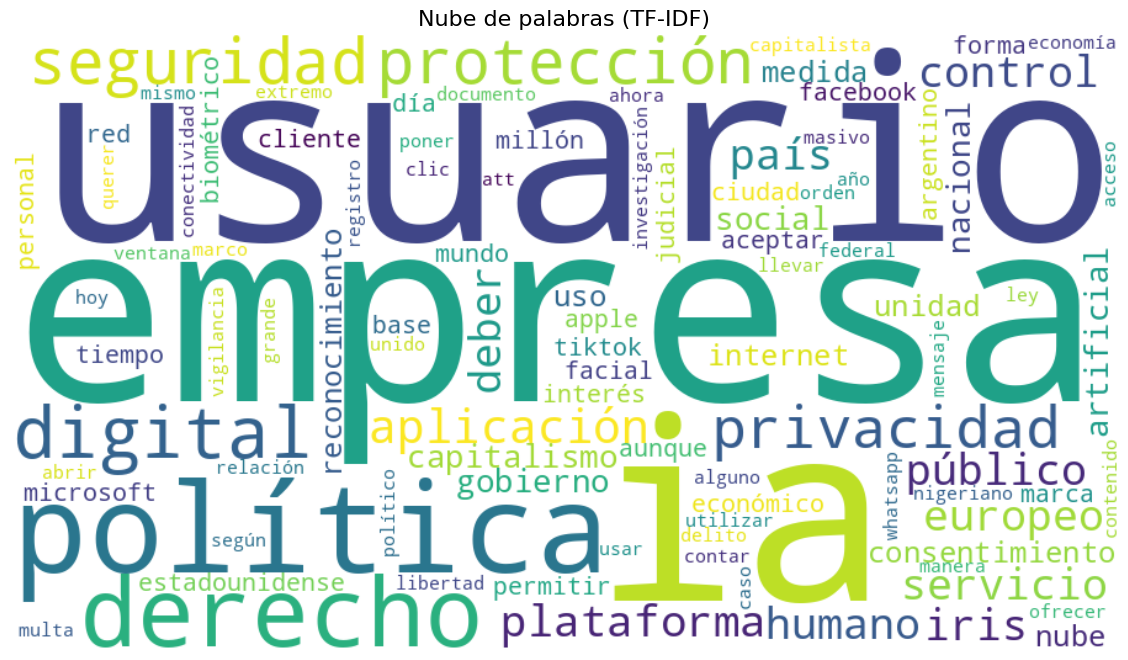

In [9]:
# Recrear la matriz TF-IDF si no la tienes ya
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_procesado'])

# Obtener la suma de TF-IDF por término
tfidf_sum = np.array(X_tfidf.sum(axis=0)).flatten()
feature_names = tfidf_vectorizer.get_feature_names_out()

# Crear un diccionario de términos y sus puntuaciones TF-IDF
tfidf_dict = {word: score for word, score in zip(feature_names, tfidf_sum)}

# Generar la nube de palabras
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=100,
    colormap="viridis",
    collocations=False
).fit_words(tfidf_dict)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras (TF-IDF)", fontsize=16)
plt.show()

#### Gráfico de barras con términos más frecuentes (BoW)

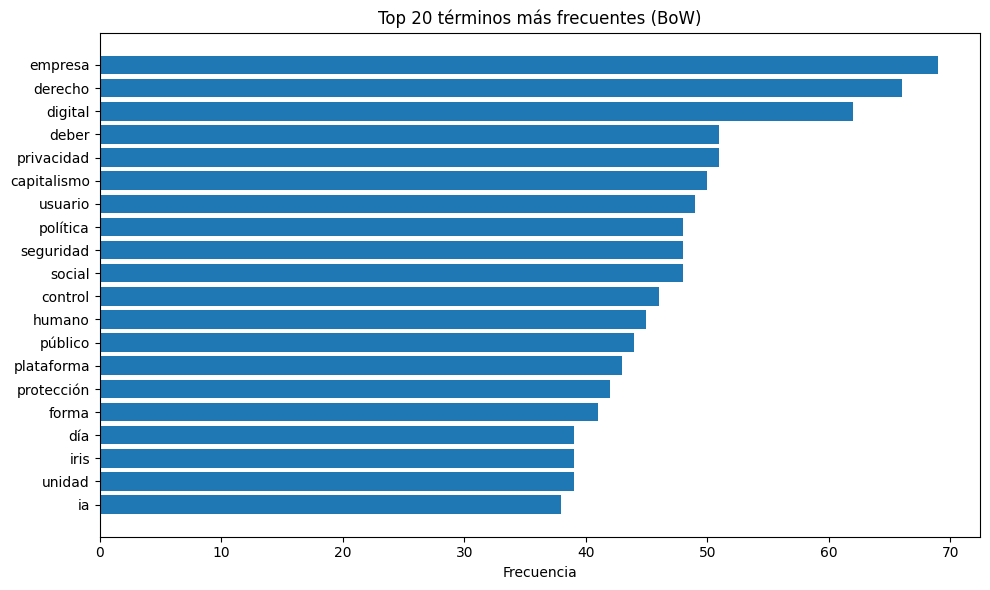

In [10]:
# Recrear la matriz CountVectorizer si no la tienes ya
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(df['texto_procesado'])

# Obtener la suma de conteos por término
counts_sum = np.array(X_counts.sum(axis=0)).flatten()
feature_names = count_vectorizer.get_feature_names_out()

# Crear un DataFrame de los términos más frecuentes
freq_df = pd.DataFrame({'Término': feature_names, 'Frecuencia': counts_sum})
top_20_bow = freq_df.nlargest(20, 'Frecuencia')

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_20_bow['Término'], top_20_bow['Frecuencia'])
plt.xlabel('Frecuencia')
plt.title('Top 20 términos más frecuentes (BoW)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Comparación BoW vs TF-IDF en barras de frecuencias


**Problema**

Los valores presentados en BoW y TF-IDF son de escalas diferentes, por lo tanto es necesario un procesamiento de los resultados para poder hacerlos comparables.

BoW representa conteos absolutos de palabras.
TF-IDF, en cambio, representa la importancia relativa de una palabra en un documento específico, ajustada por lo común que es en el resto del corpus. Sus valores suelen ser decimales pequeños.

En tal caso, estaremos escalandolos para que queden con una magnitud similar.

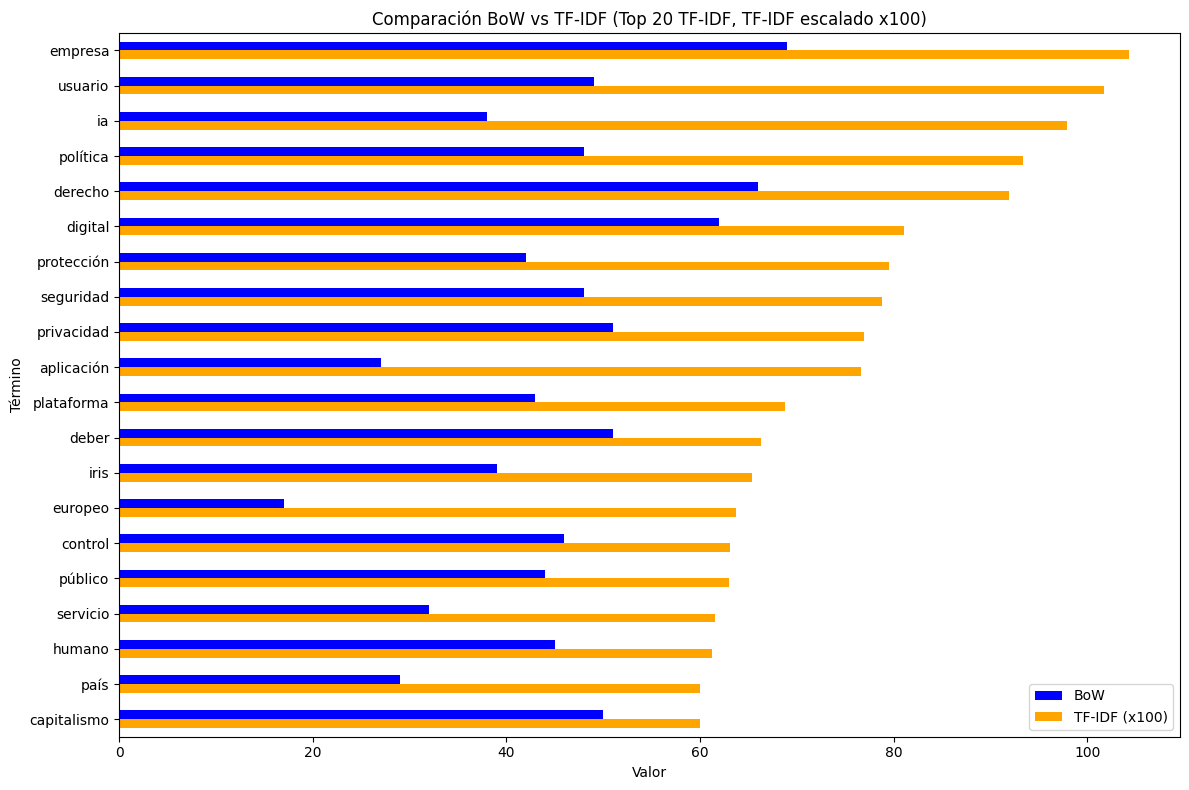

In [11]:
# Crear un DataFrame de comparación
comparison_df = pd.DataFrame({
    'Término': feature_names,
    'TF-IDF': tfidf_sum,
    'BoW': counts_sum
})

# Escalar TF-IDF multiplicándolo por un factor (por ejemplo, 100 o 200)
factor = 100  # Ajusta este valor según tu corpus
comparison_df['TF-IDF_scaled'] = comparison_df['TF-IDF'] * factor

# Mostrar top 20 según TF-IDF (escalado)
top_20_comparison = comparison_df.nlargest(20, 'TF-IDF')

# Gráfico de barras doble con TF-IDF escalado
top_20_comparison.set_index('Término')[['BoW', 'TF-IDF_scaled']].plot(
    kind='barh',
    figsize=(12, 8),
    title='Comparación BoW vs TF-IDF (Top 20 TF-IDF, TF-IDF escalado x100)',
    color=['blue', 'orange']
)
plt.gca().invert_yaxis()
plt.xlabel('Valor')
plt.legend(['BoW', 'TF-IDF (x100)'])
plt.tight_layout()
plt.show()

#### Mapa de calor de similitud de documentos (Heat-map)

In [12]:
# Calcular la matriz de similitud coseno si no la tienes ya
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(X_tfidf)

# Mostrar heatmap solo si no hay demasiados documentos
if cosine_sim_matrix.shape[0] <= 20:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_sim_matrix, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Heatmap de similitud coseno entre documentos")
    plt.show()
else:
    print("Demasiados documentos para mostrar un heatmap claro. Omitiendo.")

Demasiados documentos para mostrar un heatmap claro. Omitiendo.


##### Intento de reduccion de sample de DF

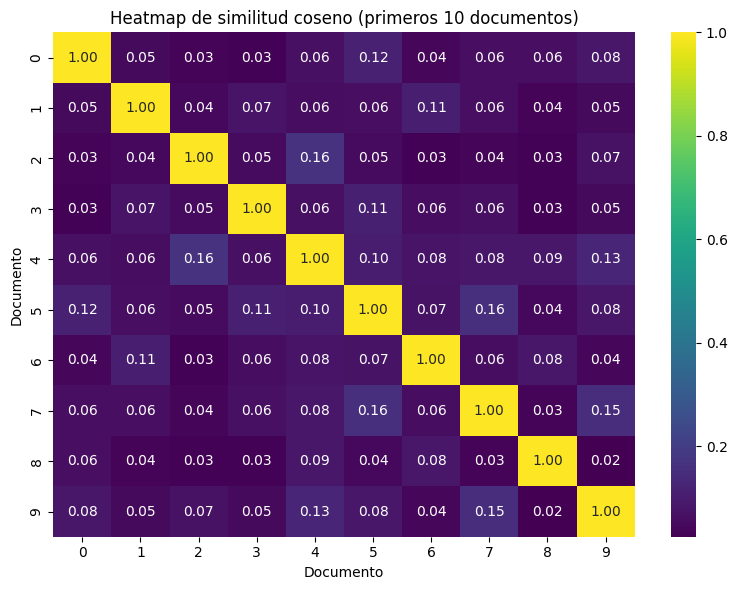

In [13]:
# Mostrar heatmap solo para los primeros 10 documentos
n_docs_to_show = min(10, cosine_sim_matrix.shape[0])  # No mostrar más de 10

plt.figure(figsize=(8, 6))
sns.heatmap(
    cosine_sim_matrix[:n_docs_to_show, :n_docs_to_show],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=range(n_docs_to_show),
    yticklabels=range(n_docs_to_show)
)
plt.title(f"Heatmap de similitud coseno (primeros {n_docs_to_show} documentos)")
plt.xlabel("Documento")
plt.ylabel("Documento")
plt.tight_layout()
plt.show()

### 3.5 Interpretación de resultados

#### Patrones en corpus - Términos y Archivos

A raíz de lo observado en la salida de mi TF-IDF y BoW, logro obtener un patrón donde se cobra relevancia a a los términos de tecnologías de Inteligencia artifical ("ia"), al término derecho junto a protección, y capitalismo.

Yendo por la similitud en los archivos, las similitudes obtenidas a raíz de los primeros 3 pares más relevantes me generan conformidad ya que por lo menos por el primer documento, sé que se habla del mismo tema (Tecnovigilancia en la Ciudad de Buenos Aires); así como también sobre el tercer documento (Intento de conexión "empática" entre humanos y tecnologías de IA). Este último item puede dar solidez a ciertas palabras pesadas como capitalismo, derecho y deber.

#### Agrupaciones naturales

Para este item deberemos hacer un análisis extra por medio de clustering. Intentaremos hacer un approach con K-Means y luego un agrupammiento jerárquico de nuestros términos

In [19]:
from sklearn.cluster import KMeans

# Aplicar K-Means
k = 5  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Añadir la etiqueta de cluster al DataFrame
df['cluster'] = clusters

# Ver qué documentos pertenecen a cada cluster
for cluster_id in range(k):
    print(f"\nCluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['titulo'].values)


Cluster 0:
['El auge del tecnofeudalismo | ANRed'
 'Cómo las grandes empresas tech lograron meterse en nuestra cama | Entrevista a\xa0Tomás Balmaceda'
 'Sam Altman, creador de ChatGPT y GPT-4: «mi peor temor es que causemos un daño significativo al mundo» | ANRed'
 'Marcas enfrentan el desafío de reforzar la conexión humana en la era de la inteligencia artificial']

Cluster 1:
['La era del capitalismo digital: magnates tecnológicos y outsiders políticos | Se avanza hacia una forma de "democracia digital hueca".'
 'Chat Control: el plan europeo para escanear tus mensajes'
 'Microsoft mantendrá en la UE los datos personales de sus clientes europeos'
 'Manzana podrida: decenas de exespías israelíes fueron contratados por Apple, el gigante de Silicon Valley | ANRed'
 'Pandemia de control digital | ANRed'
 'Natalia Zuazo: «el problema es cuando el avance de la tecnología lo que hace es explotarnos o quitarnos derechos» | ANRed']

Cluster 2:
['Polisis: una IA que se lee las políticas de pri

A raíz de estos clusters, podemos confluir en el corpus seleccionado trae consigo varios temas con agrupaciones relativamente balanceadas.

La agrupación de menor volumen es el Cluster 0 al disponer de menos items en sí.

Las agrupaciones que noto que tienen mayor cohesión natural son los Clusters 0, 3 y 4



#### Posibles limitaciones

El mayor límite que encuentro en el enfoque que he dado tiene que ver con la escala de la hipótesis que plantié, ya que para corroborar alguna posible razón por la que se ha dejado de mencionar el tema de privacidad de datos, necesito de un corpus mayor, mayor variedad de fuentes, y hacer un análisis con tecnologías diferentes que no he aplicado en este Integrador.

Un ejemplo a primera vista que podría haber usado para esto es un análisis de sentimiento, pero aún así se queda corto a largos rasgos.


## Análisis con Word Embeddings

### 4.1 Aplicación de embeddings

In [3]:
# Cargar modelo de spaCy con embeddings
!python -m spacy download es_core_news_md
nlp = spacy.load("es_core_news_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**¿Por qué es_core_news_md es diferente de es_core_news_sm?**

- es_core_news_sm: Modelo pequeño, sin word vectors (embeddings).
- es_core_news_md: Modelo mediano, con word vectors (embeddings preentrenados), necesario para esta parte de la tarea.

In [4]:
# Cargar el DataFrame con los textos limpios
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/develop/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3_stopwords.pkl"
df = pd.read_pickle(github_pkl_path)

# Reconstruir los documentos como cadenas de texto
df['texto_procesado'] = df['tokens_sin_stopwords'].apply(lambda x: ' '.join(x))

# Función para obtener el vector promedio de un documento
def get_doc_vector(text):
    doc = nlp(text)
    # Filtrar tokens que tengan vector (no todos los tokens tienen embeddings)
    vectors = [token.vector for token in doc if token.has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Si no hay vectores, devolver un vector de ceros
        return np.zeros(nlp.vocab.vectors_length)

# Aplicar la función a cada documento
df['doc_vector'] = df['texto_procesado'].apply(get_doc_vector)

# Mostrar dimensiones del vector de un documento (debe ser 300 para es_core_news_md)
print("Dimensión del vector de un documento promedio:", len(df['doc_vector'].iloc[0]))

Dimensión del vector de un documento promedio: 300


In [5]:
# Ver cuántos documentos tienen un vector
print(f"Número de documentos procesados: {len(df['doc_vector'])}")

# Verificar que todos tengan la misma longitud (300 para es_core_news_md)
longitudes = df['doc_vector'].apply(lambda x: len(x))
print(f"Todas las longitudes son 300? {all(longitudes == 300)}")

# Ver el vector del primer documento (como ejemplo)
print("Vector del primer documento (primeros 10 valores):")
print(df['doc_vector'].iloc[0][:10])

Número de documentos procesados: 26
Todas las longitudes son 300? True
Vector del primer documento (primeros 10 valores):
[ 0.6361936   0.9821791  -0.30583698 -0.35561225  0.27013287 -0.2520335
 -1.0734458   0.61797905 -0.67095304  1.5112191 ]


#### Qué son los Embeddings?

Representan cada palabra como un vector denso en un espacio continuo, donde palabras con significados similares están más cerca. Se puede promediar para representar un documento.

Mientras que los BoW representan cada documento como un vector de conteo de palabras, este no considera el
orden ni el significado de las palabras.

Las ventajas aparentes en el uso de Embeddings son:
- Capturan semántica y relaciones entre palabras.
- Palabras como "gobierno" y "estado" estarán más cerca que con BoW.
- Permiten operaciones como combinatorias de palabras

### 4.2 Análisis de similitud semántica

#### Comparacion entre documentos

Convierto valores a una matriz

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Convertir la columna 'doc_vector' en una matriz (Documentos x Embeddings)
doc_vectors_matrix = np.vstack(df['doc_vector'].values)

# Calcular la matriz de similitud coseno entre todos los pares de documentos
cosine_sim_embeddings = cosine_similarity(doc_vectors_matrix)

# Mostrar dimensiones
print("Dimensiones de la matriz de similitud con embeddings (Documentos x Documentos):", cosine_sim_embeddings.shape)

Dimensiones de la matriz de similitud con embeddings (Documentos x Documentos): (26, 26)


#### Comparacion con TF-IDF

In [7]:
# Obtener los pares más similares según embeddings (mismo código que antes, pero ahora con embeddings)
def get_top_pairs(sim_matrix, top_n=3):
    pairs = []
    n_docs = sim_matrix.shape[0]
    for i in range(n_docs):
        for j in range(i + 1, n_docs):  # Evitar duplicados y diagonal (i, i)
            pairs.append((i, j, sim_matrix[i, j]))

    # Ordenar por similitud (de mayor a menor)
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:top_n]

top_similar_pairs_embeddings = get_top_pairs(cosine_sim_embeddings, top_n=3)

print("\nPares más similares según embeddings:")
for i, j, sim in top_similar_pairs_embeddings:
    print(f"Documento {i} - Documento {j}: {sim:.4f}")


Pares más similares según embeddings:
Documento 14 - Documento 25: 0.9758
Documento 2 - Documento 14: 0.9741
Documento 2 - Documento 25: 0.9710


#### Recarga matriz coseno

In [9]:
# Asegurarnos de que los documentos estén como cadenas de texto
df['texto_procesado'] = df['tokens_sin_stopwords'].apply(lambda x: ' '.join(x))

# Recrear las matrices TF-IDF (por si las dudas)
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_procesado'])

# Calcular la matriz de similitud coseno entre todos los pares de documentos
cosine_sim_matrix = cosine_similarity(X_tfidf)

# Mostrar dimensiones de la matriz de similitud
print("Dimensiones de la matriz de similitud coseno (Documentos x Documentos):", cosine_sim_matrix.shape)

Dimensiones de la matriz de similitud coseno (Documentos x Documentos): (26, 26)


In [10]:
# Asumiendo que ya tienes cosine_sim_matrix de TF-IDF
top_similar_pairs_tfidf = get_top_pairs(cosine_sim_matrix, top_n=3)

print("\nPares más similares según TF-IDF:")
for i, j, sim in top_similar_pairs_tfidf:
    print(f"Documento {i} - Documento {j}: {sim:.4f}")


Pares más similares según TF-IDF:
Documento 2 - Documento 25: 0.3174
Documento 5 - Documento 19: 0.2579
Documento 7 - Documento 17: 0.2427


In [11]:
# Comparar pares
print("\n¿Coinciden los pares más similares entre embeddings y TF-IDF?")
embeddings_pairs = [(i, j) for i, j, _ in top_similar_pairs_embeddings]
tfidf_pairs = [(i, j) for i, j, _ in top_similar_pairs_tfidf]

for pair in embeddings_pairs:
    if pair in tfidf_pairs or (pair[1], pair[0]) in tfidf_pairs:
        print(f"Sí, {pair} está en ambos.")
    else:
        print(f"No, {pair} no está en TF-IDF.")


¿Coinciden los pares más similares entre embeddings y TF-IDF?
No, (14, 25) no está en TF-IDF.
No, (2, 14) no está en TF-IDF.
Sí, (2, 25) está en ambos.


A raíz de una comparativa, hay una disparidad entre los 3 pares de documentos más similares.

Aún así se puede concretar que los documentos 2 y 25 mantienen la similitud, lo cual es buena señal considerando las diferencias de cálculo entre Embeddings y TF-IDF, dado que ésta ultima captura términos comunes y distintivos **sin calcular relaciones semánticas.**

### 4.3 Búsqueda de analogías relevantes al corpus

In [13]:
# Asegúrate de tener el modelo cargado
!python -m spacy download es_core_news_md
nlp = spacy.load("es_core_news_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 25.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
# Términos clave de tu dominio
terminos_clave = ["política", "derecho", "privacidad", "inteligencia artificial", "capitalismo", "seguridad", "vigilancia"]

for termino in terminos_clave:
    token = nlp(termino)
    if token.has_vector:
        # Obtener las 10 palabras más similares
        similitudes = []
        for palabra in nlp.vocab:
            if palabra.has_vector and palabra.is_alpha and palabra.lower_ != termino:
                sim = token.similarity(palabra)
                similitudes.append((palabra.lower_, sim))
        # Ordenar por similitud
        similitudes.sort(key=lambda x: x[1], reverse=True)
        print(f"\nPalabras similares a '{termino}':")
        for palabra, sim in similitudes[:10]:
            print(f"  {palabra}: {sim:.4f}")
    else:
        print(f"\n'{termino}' no tiene vector en el modelo.")


Palabras similares a 'política':
  e: 0.2651
  y: 0.2400
  a: 0.1970
  gral: 0.1934
  pág: 0.1697
  uu: 0.1635
  dpto: 0.1471
  ee: 0.1208
  b: 0.1135
  dna: 0.1000

Palabras similares a 'derecho':
  política: 0.4498
  dpto: 0.3009
  b: 0.2655
  o: 0.2647
  fig: 0.2027
  c: 0.2027
  vd: 0.1894
  ud: 0.1894
  a: 0.1836
  u: 0.1685

Palabras similares a 'privacidad':
  derecho: 0.4981
  política: 0.4427
  dpto: 0.3558
  vd: 0.2755
  ud: 0.2755
  o: 0.2384
  a: 0.1703
  y: 0.1692
  u: 0.1584
  b: 0.1570

Palabras similares a 'inteligencia artificial':
  inteligencia: 0.9108
  artificial: 0.8475
  política: 0.4933
  privacidad: 0.4868
  derecho: 0.3059
  y: 0.3005
  dpto: 0.2878
  e: 0.2271
  uu: 0.1767
  o: 0.1696

Palabras similares a 'capitalismo':
  política: 0.6778
  inteligencia: 0.5332
  derecho: 0.4202
  artificial: 0.3245
  privacidad: 0.2905
  dpto: 0.2693
  y: 0.2394
  ä: 0.2042
  e: 0.1764
  a: 0.1455

Palabras similares a 'seguridad':
  privacidad: 0.6943
  inteligencia: 0.66

#### Creación de analogías


In [29]:
def encontrar_mas_similar_a(a, b, c, modelo):
    """
    Encuentra d tal que a - b + c ≈ d
    """
    a_vec = modelo(a).vector
    b_vec = modelo(b).vector
    c_vec = modelo(c).vector

    # Calcular el vector objetivo
    resultado = a_vec - b_vec + c_vec

    # Buscar la palabra más similar
    similitudes = []
    for palabra in modelo.vocab:
        if palabra.has_vector and palabra.is_alpha:
            sim = np.dot(resultado, palabra.vector) / (np.linalg.norm(resultado) * np.linalg.norm(palabra.vector))
            similitudes.append((palabra.lower_, sim))

    # Ordenar por similitud
    similitudes.sort(key=lambda x: x[1], reverse=True)
    return similitudes[:10]


In [30]:
# Ejemplo de analogía: "gobierno" - "ley" + "empresa" = ?
analogia_resultado = encontrar_mas_similar_a("gobierno", "ley", "empresa", nlp)
print("\nAnalogía: 'gobierno' - 'ley' + 'empresa' ≈")
for palabra, sim in analogia_resultado[:5]:
    print(f"  {palabra}: {sim:.4f}")


Analogía: 'gobierno' - 'ley' + 'empresa' ≈
  empresa: 0.3656
  ing: 0.1846
  cía: 0.1767
  gobierno: 0.1762
  dpto: 0.1553


In [31]:
# política - seguridad + derecho = ?
analogia_resultado = encontrar_mas_similar_a("política", "seguridad", "derecho", nlp)
print("\nAnalogía: 'política' - 'seguridad' + 'derecho' ≈")
for palabra, sim in analogia_resultado[:5]:
    print(f"  {palabra}: {sim:.4f}")


Analogía: 'política' - 'seguridad' + 'derecho' ≈
  derecho: 0.7556
  política: 0.6901
  capitalismo: 0.5302
  gobierno: 0.4647
  ley: 0.4530


In [32]:
# capitalismo - empresa + control = ?
analogia_resultado = encontrar_mas_similar_a("capitalismo", "empresa", "control", nlp)
print("\nAnalogía: 'capitalismo' - 'empresa' + 'control' ≈")
for palabra, sim in analogia_resultado[:5]:
    print(f"  {palabra}: {sim:.4f}")


Analogía: 'capitalismo' - 'empresa' + 'control' ≈
  control: 0.7033
  capitalismo: 0.6414
  política: 0.4071
  inteligencia: 0.4001
  gobierno: 0.3994


In [33]:
# plataforma - aplicación + privacidad
analogia_resultado = encontrar_mas_similar_a("plataforma", "aplicación", "privacidad", nlp)
print("\nAnalogía: 'plataforma' - 'aplicación' + 'privacidad' ≈")
for palabra, sim in analogia_resultado[:5]:
    print(f"  {palabra}: {sim:.4f}")


Analogía: 'plataforma' - 'aplicación' + 'privacidad' ≈
  privacidad: 0.6522
  plataforma: 0.5259
  seguridad: 0.3276
  empresa: 0.3109
  dpto: 0.2143


#### Interpretación de analogías

Tienen sentido las analogías?

Yo diria que sí, pero se mezclan muchos resultados con y sin acentos que podrían ser usados por otros términos que quizas aporten mejores similitudes reales.

De igual forma, las palabras obtenidas tienen relación con términos clave de mayor tendencia en el corpus.

### 4.4 Comparación con resultados de BoW

In [15]:
# Suponiendo que ya tienes ambas matrices:
# cosine_sim_embeddings (de embeddings)
# cosine_sim_matrix (de TF-IDF)

def get_top_pairs(sim_matrix, top_n=3):
    pairs = []
    n_docs = sim_matrix.shape[0]
    for i in range(n_docs):
        for j in range(i + 1, n_docs):  # Evitar duplicados y diagonal (i, i)
            pairs.append((i, j, sim_matrix[i, j]))

    # Ordenar por similitud (de mayor a menor)
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:top_n]

top_similar_pairs_embeddings = get_top_pairs(cosine_sim_embeddings, top_n=3)
top_similar_pairs_tfidf = get_top_pairs(cosine_sim_matrix, top_n=3)

#### Creo tabla comparativa

In [16]:
# Asumiendo que ya tienes:
# - top_similar_pairs_embeddings
# - top_similar_pairs_tfidf
# - df (con columna 'titulo')

# Crear DataFrames separados para cada método
df_embeddings = pd.DataFrame({
    'Método': 'Embeddings',
    'Doc A': [df.iloc[i]['titulo'] for i, _, _ in top_similar_pairs_embeddings],
    'Doc B': [df.iloc[j]['titulo'] for _, j, _ in top_similar_pairs_embeddings],
    'Similitud': [sim for _, _, sim in top_similar_pairs_embeddings],
    'Índice A': [i for i, _, _ in top_similar_pairs_embeddings],
    'Índice B': [j for _, j, _ in top_similar_pairs_embeddings]
})

df_tfidf = pd.DataFrame({
    'Método': 'TF-IDF',
    'Doc A': [df.iloc[i]['titulo'] for i, _, _ in top_similar_pairs_tfidf],
    'Doc B': [df.iloc[j]['titulo'] for _, j, _ in top_similar_pairs_tfidf],
    'Similitud': [sim for _, _, sim in top_similar_pairs_tfidf],
    'Índice A': [i for i, _, _ in top_similar_pairs_tfidf],
    'Índice B': [j for _, j, _ in top_similar_pairs_tfidf]
})

# Mostrar cada uno por separado
print("=== Pares más similares según Embeddings ===")
print(df_embeddings[['Método', 'Doc A', 'Doc B', 'Similitud']].to_string(index=False))

print("\n=== Pares más similares según TF-IDF ===")
print(df_tfidf[['Método', 'Doc A', 'Doc B', 'Similitud']].to_string(index=False))

=== Pares más similares según Embeddings ===
    Método                                                                                                                                           Doc A                                                                                                                                           Doc B  Similitud
Embeddings Bullrich desatada: autorizó a la Policía Federal a realizar ciberpatrullaje y requisas sin orden judicial | La letra chica del polémico decreto                                     CABA: la Legislatura porteña debate un polémico proyecto sobre tecnologías de reconocimiento facial | ANRed   0.975785
Embeddings                           Espionaje ilegal del Ministerio de Seguridad porteño: buscó los datos biométricos de 7,5 millones de personas | ANRed Bullrich desatada: autorizó a la Policía Federal a realizar ciberpatrullaje y requisas sin orden judicial | La letra chica del polémico decreto   0.974132
Embeddings               

In [36]:
def truncate_title(title, max_len=40):
    return title if len(title) <= max_len else title[:max_len] + "..."

# Aplicar truncado
df_embeddings['Doc A'] = df_embeddings['Doc A'].apply(truncate_title)
df_embeddings['Doc B'] = df_embeddings['Doc B'].apply(truncate_title)
df_tfidf['Doc A'] = df_tfidf['Doc A'].apply(truncate_title)
df_tfidf['Doc B'] = df_tfidf['Doc B'].apply(truncate_title)

print("=== Comparativa con títulos truncados ===")
print(df_embeddings[['Método', 'Doc A', 'Doc B', 'Similitud']].to_string(index=False))
print("\n=== TF-IDF ===")
print(df_tfidf[['Método', 'Doc A', 'Doc B', 'Similitud']].to_string(index=False))

=== Comparativa con títulos truncados ===
    Método                                       Doc A                                       Doc B  Similitud
Embeddings Bullrich desatada: autorizó a la Policía... CABA: la Legislatura porteña debate un p...   0.975785
Embeddings Espionaje ilegal del Ministerio de Segur... Bullrich desatada: autorizó a la Policía...   0.974132
Embeddings Espionaje ilegal del Ministerio de Segur... CABA: la Legislatura porteña debate un p...   0.971015

=== TF-IDF ===
Método                                       Doc A                                       Doc B  Similitud
TF-IDF Espionaje ilegal del Ministerio de Segur... CABA: la Legislatura porteña debate un p...   0.317412
TF-IDF La era del capitalismo digital: magnates... Globalización recargada: nuevos nacional...   0.257912
TF-IDF Cómo las grandes empresas tech lograron ... Marcas enfrentan el desafío de reforzar ...   0.242664


#### Interpretaciones

Los resultados pueden ser más intuitivos dependiendo del análisis que se quiera hacer.

Si se busca un análisis relativamente superficial, TF-IDF puede dar resultados más fáciles de interpretar si los documentos comparten términos comunes.

Pero para algo más profundo, se recomienda Embeddings pero puede ser menos intuitivo si no se entiende bien cómo funcionan los vectores semánticos.

---

Se recomienda usar Embeddings para los casos de análisis que requieran una comprensión a través de relaciones indirectas como lo sería una regla semántica y que no implique necesariamente que las palabras sean idénticas.

En estos casos, Embeddings supera a BoW en utilidad.

---

De forma simultanea, si se trata con un corpus de gran tamaño y/o no se requiere de un análisis profundo de corpus, BoW es suficiente para la tarea, ya que puede aportarnos suficiente contexto de similitud a un costo relativamente bajo de procesamiento de cómputo.

Recordemos que embeddings requiere de un procesamiento extra de los datos (pasamos de usar un modelo pequeño de spacy a uno mayor para esta tarea).



### 4.5 Visualización de embeddings (si es posible)

Para reducir la dimensionalidad, vamos a usar T-SNE

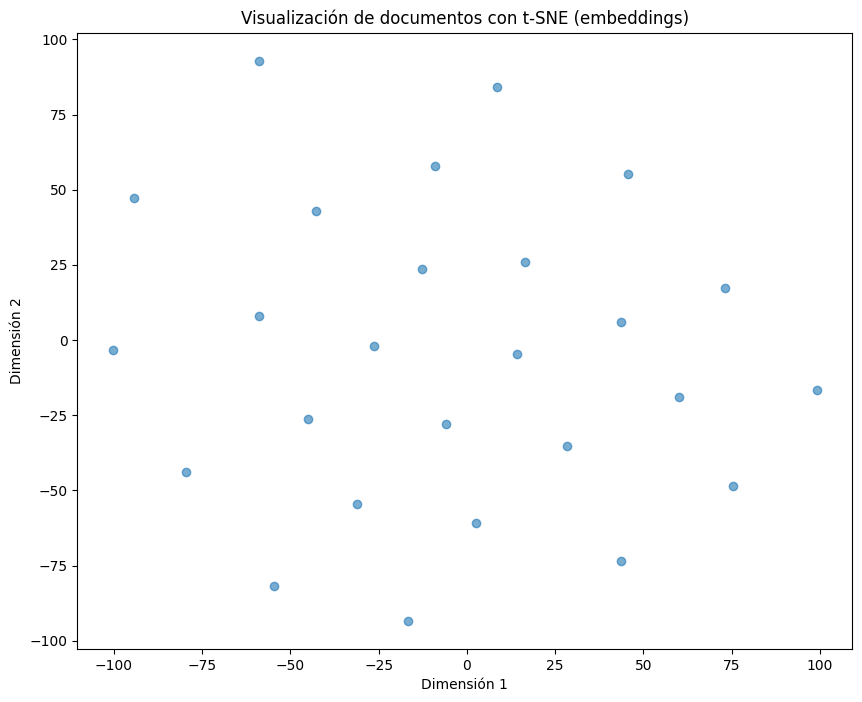

In [23]:
# Ajustar perplexity a un valor menor que el número de documentos (26)
n_docs = doc_vectors_matrix.shape[0]  # Esto debería ser 26
perplexity = min(20, n_docs - 1)  # Asegurar que sea menor que n_samples, por ejemplo 20 o 25

X_tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity).fit_transform(doc_vectors_matrix)

# Graficar
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title("Visualización de documentos con t-SNE (embeddings)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

A raíz del grafico puedo notar que no hay una agrupación clara, pero parece ser esperable considerando el tamaño de mi corpus.


> Según una explicación dada por Qwen:
t-SNE no preserva la estructura global, solo la estructura local. Es decir, si dos puntos están cerca en el espacio original (embeddings), t-SNE intentará mantenerlos cerca en 2D.

> Si los documentos no tienen una estructura clara de agrupación (por ejemplo, todos tratan sobre temas relacionados pero no forman clusters bien definidos), t-SNE puede mostrar puntos dispersos.

> Con solo 26 documentos, es difícil que se formen agrupaciones visuales claras, especialmente si los temas son variados.


In [24]:
### Recarga de clusters si falla
from sklearn.cluster import KMeans

# Aplicar K-Means
k = 5  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Añadir la etiqueta de cluster al DataFrame
df['cluster'] = clusters

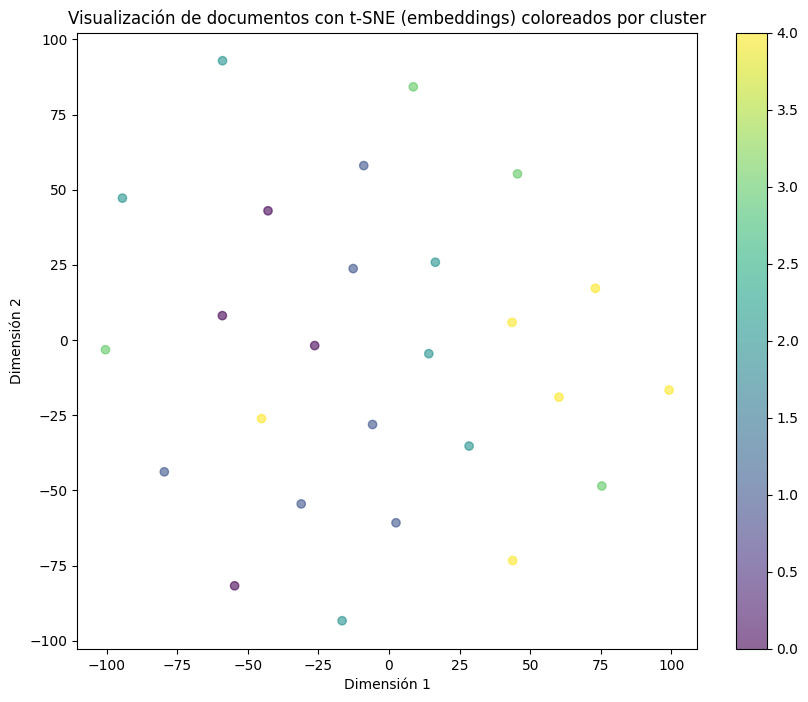

In [25]:
# Asumiendo que tienes una columna 'cluster' en df
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title("Visualización de documentos con t-SNE (embeddings) coloreados por cluster")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

#### Intento con PCA

Los resultados obtenidos con t-SNE no me convencieron del todo, así que pruebo con PCA para obtener una visibilidad diferente de agrupaciones


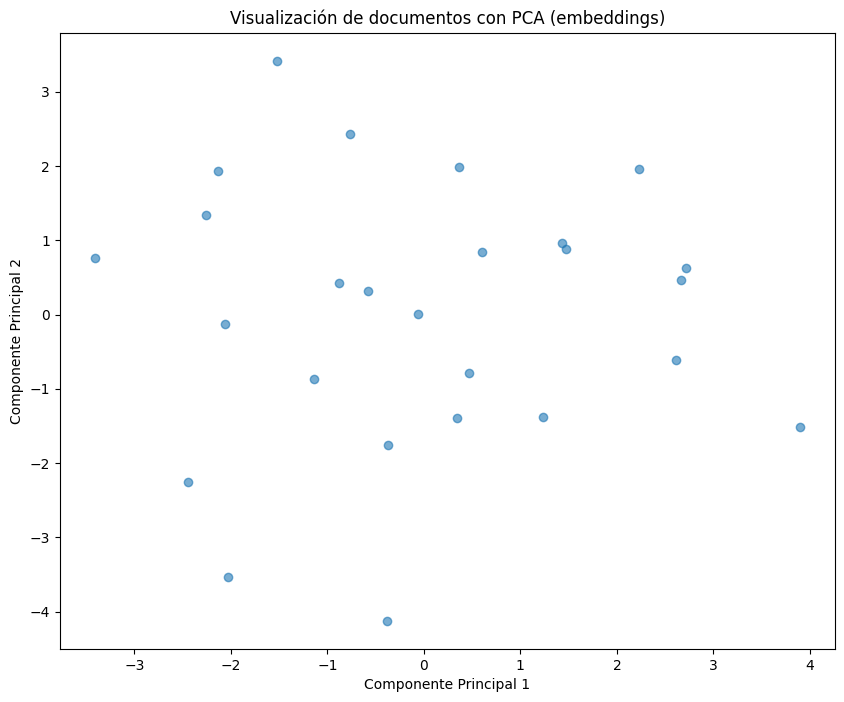

In [26]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2, random_state=42).fit_transform(doc_vectors_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("Visualización de documentos con PCA (embeddings)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

## Análisis Complementario

Se elije un análisis complementario usando Extracción Básica de Entidades

### Referencia de Tipos de entidades comunes en spaCy (para español)
- PER/PERSON -
Personas (nombres propios de personas).

- ORG -
Organizaciones (empresas, instituciones).

- LOC/GPE -
Lugares (ciudades, países, regiones).

- MISC -
Otras entidades misceláneas.

- DATE -
Fechas.

- TIME -
Horas.

- MONEY -
Cantidades monetarias.

### Código

Ya tenemos el modelo es_core_news_md cargado, que incluye un reconocedor de entidades nombradas (NER) entrenado para español.

In [29]:
# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_md")

# Cargar dataframe
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/develop/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3_stopwords.pkl"
df = pd.read_pickle(github_pkl_path)

# Reconstruir los documentos como cadenas de texto
df['texto_procesado'] = df['tokens_sin_stopwords'].apply(lambda x: ' '.join(x))

# Función para extraer entidades de un texto
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Aplicar la función a cada documento
df['entities'] = df['texto_procesado'].apply(extract_entities)

# Mostrar ejemplo de entidades extraídas de un documento
print("Ejemplo de entidades extraídas del primer documento:")
print(df['entities'].iloc[0])

Ejemplo de entidades extraídas del primer documento:
[('yanis varoufakis', 'PER'), ('pordavid', 'LOC'), ('florencia', 'LOC'), ('grecia', 'LOC'), ('entecnofeudalismodeusto', 'PER'), ('marx', 'PER'), ('henry ford', 'PER'), ('spock', 'PER'), ('rosa luxemburgo socialismo', 'PER'), ('inglaterra', 'LOC'), ('llamadaotr', 'PER'), ('internet', 'MISC'), ('robert owen', 'PER'), ('amazon', 'MISC'), ('arremangurm', 'LOC'), ('henry ford', 'PER'), ('rupert murdoch', 'PER'), ('europa', 'LOC'), ('jeff bezo elon musk', 'PER'), ('edison', 'PER'), ('bretton woods', 'MISC'), ('bretton woods', 'PER'), ('john maynard keynes', 'PER'), ('harry dexter', 'PER'), ('white', 'PER'), ('california', 'MISC'), ('wall street wall street', 'MISC'), ('wall street', 'MISC'), ('bank of america monedero', 'ORG'), ('fed bank of america', 'MISC'), ('bank of america', 'ORG'), ('alo mail redaccionanredorg', 'PER')]


(Ya note algunas cosas raras aca jajaja)

#### Contar entidades por tipo

In [30]:
# Contar entidades por tipo (PERSON, ORG, LOC, etc.)
all_entities = [ent for entities in df['entities'] for ent in entities]
entities_by_type = {}

for text, label in all_entities:
    if label not in entities_by_type:
        entities_by_type[label] = []
    entities_by_type[label].append(text)

# Contar frecuencia de cada tipo
entity_counts = {label: Counter(entities) for label, entities in entities_by_type.items()}

# Mostrar top 10 de cada tipo
for label, counter in entity_counts.items():
    print(f"\nTop 10 entidades de tipo '{label}':")
    for entity, count in counter.most_common(10):
        print(f"  {entity}: {count}")


Top 10 entidades de tipo 'PER':
  alo mail redaccionanredorg: 9
  añospáginaasumió: 7
  anred: 4
  spamconoce: 3
  omg: 3
  henry ford: 2
  enzo: 2
  moore: 2
  tim cook: 2
  medalion: 2

Top 10 entidades de tipo 'LOC':
  israel: 14
  europa: 7
  reino unido: 6
  silicon valley: 5
  eeuu: 4
  francia: 3
  argentino: 2
  madrid: 2
  gaza: 2
  rusia: 2

Top 10 entidades de tipo 'MISC':
  internet: 16
  facebook: 8
  app: 7
  amazon: 6
  whatsapp telegram: 2
  google amazon: 2
  iphone: 2
  xredsegura: 2
  bretton woods: 1
  california: 1

Top 10 entidades de tipo 'ORG':
  apple: 18
  google: 9
  microsoft: 7
  ue: 3
  ftc: 3
  world id: 2
  unesco: 2
  bank of america monedero: 1
  bank of america: 1
  cabify repsol banco santander: 1


In [31]:
# Mostrar solo los tipos más relevantes
if 'PER' in entity_counts or 'PERSON' in entity_counts:
    print("\nPersonas más mencionadas:")
    person_counts = entity_counts.get('PER', entity_counts.get('PERSON', []))
    for entity, count in person_counts.most_common(10):
        print(f"  {entity}: {count}")

if 'ORG' in entity_counts:
    print("\nOrganizaciones más mencionadas:")
    for entity, count in entity_counts['ORG'].most_common(10):
        print(f"  {entity}: {count}")

if 'LOC' in entity_counts or 'GPE' in entity_counts:
    print("\nLugares más mencionados:")
    loc_counts = entity_counts.get('LOC', entity_counts.get('GPE', []))  # GPE incluye países, ciudades, etc.
    for entity, count in loc_counts.most_common(10):
        print(f"  {entity}: {count}")


Personas más mencionadas:
  alo mail redaccionanredorg: 9
  añospáginaasumió: 7
  anred: 4
  spamconoce: 3
  omg: 3
  henry ford: 2
  enzo: 2
  moore: 2
  tim cook: 2
  medalion: 2

Organizaciones más mencionadas:
  apple: 18
  google: 9
  microsoft: 7
  ue: 3
  ftc: 3
  world id: 2
  unesco: 2
  bank of america monedero: 1
  bank of america: 1
  cabify repsol banco santander: 1

Lugares más mencionados:
  israel: 14
  europa: 7
  reino unido: 6
  silicon valley: 5
  eeuu: 4
  francia: 3
  argentino: 2
  madrid: 2
  gaza: 2
  rusia: 2


Por parte de Personas, no puedo determinar una coherencia porque al parecer en alguna parte se mezclaron varios términos diferentes que quedaron mal categorizados.

De parte de las localizaciones, se menciona primariamente a Israel y a países de Europa.

Por las organizaciones, hay menciones primarias de parte de empresas como Apple y Google, junto a alguna mención leve a Bank Of America

#### Validacion de subcategorias

In [32]:
# Asumiendo que tienes una columna 'categoria' o 'cluster'
if 'categoria' in df.columns:
    for categoria in df['categoria'].unique():
        print(f"\n--- Categoría: {categoria} ---")
        subset = df[df['categoria'] == categoria]
        all_entities_cat = [ent for entities in subset['entities'] for ent in entities]
        entities_by_type_cat = {}
        for text, label in all_entities_cat:
            if label not in entities_by_type_cat:
                entities_by_type_cat[label] = []
            entities_by_type_cat[label].append(text)

        # Contar frecuencia
        entity_counts_cat = {label: Counter(entities) for label, entities in entities_by_type_cat.items()}

        # Mostrar top 5 de cada tipo
        for label, counter in entity_counts_cat.items():
            top_5 = counter.most_common(5)
            if top_5:
                print(f"  {label}: {top_5}")


--- Categoría: Opinión ---
  PER: [('henry ford', 2), ('yanis varoufakis', 1), ('entecnofeudalismodeusto', 1), ('marx', 1), ('spock', 1)]
  LOC: [('pordavid', 1), ('florencia', 1), ('grecia', 1), ('inglaterra', 1), ('arremangurm', 1)]
  MISC: [('internet', 1), ('amazon', 1), ('bretton woods', 1), ('california', 1), ('wall street wall street', 1)]
  ORG: [('bank of america monedero', 1), ('bank of america', 1)]

--- Categoría: Cyber ---
  PER: [('spamconoce', 1)]

--- Categoría: Derechos Humanos ---
  PER: [('marcelo d alessandro', 1), ('rodríguez larreto', 1), ('roberto andrés gallardo', 1), ('alberto fernández', 1), ('eduardo belliboni juan grabois myriam bregman', 1)]
  MISC: [('renaper', 1)]

--- Categoría: Agencia Informativa ---
  LOC: [('europa', 1), ('francia', 1)]
  MISC: [('app', 2)]
  PER: [('desarrolladoresshane bauer', 1), ('att', 1)]

--- Categoría: Ciencia y Tecnología ---
  LOC: [('israel', 13), ('silicon valley', 5), ('eeuu', 3), ('madrid', 2), ('gaza', 2)]
  MISC: [('

Tomando estos outputs, no noto suficientes diferencias entre categorías dado que el taggeo realizado en la obtención inicial del corpus, se mezclaron varios términos y ensucia un poco el análisis complementario


## Datos de commiteo - Ignorar

In [ ]:
## Para commits, guardar ruta como
## 003_barthou-gonzalo-nlp-integrador/notebook/analisis_integrador.ipynb